## Package and setup

In [48]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForestModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
from darts.utils.utils import generate_index
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


COLORS = {
    'IHSG': '#2E7D32',
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'Inflation': '#D32F2F',
    'BI_Rate': '#F57C00',        
    'M2_YoY': '#1976D2',         
    'USDIDR': '#7B1FA2',         
    'NPL_Ratio': '#C2185B',      
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B']

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# line 
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# grid
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# legend
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

## Data gathering and preprocessing

In [3]:
# data from bloomberg terminal
df = pd.read_csv('dataset/model1.csv')

# display basic info
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print("\n" + "="*60)
print("FIRST 10 ROWS")
print("="*60)
df.head(10)

DATA OVERVIEW
Shape: 121 rows × 7 columns

Columns: ['Date', 'IHSG', 'Inflation Rate YoY', 'Money Supply M2 YoY', 'USDIDR', 'BI Interest Rate', 'npl_ratio']

FIRST 10 ROWS


,Date,IHSG,Inflation Rate YoY,Money Supply M2 YoY,USDIDR,BI Interest Rate,npl_ratio
0,31/01/2025,7109.196,0.76,5.46,16300,5.75%,2.18%
1,31/12/2024,7079.905,1.57,4.76,16102,6.00%,2.08%
2,30/11/2024,7114.266,1.55,6.53,15845,6.00%,2.19%
3,31/10/2024,7574.019,1.71,6.77,15697,6.00%,2.20%
4,30/09/2024,7527.929,1.84,7.19,15140,6.00%,2.21%
5,31/08/2024,7670.733,2.12,7.30,15455,6.25%,2.26%
6,31/07/2024,7255.762,2.13,7.59,16260,6.25%,2.27%
7,30/06/2024,7063.577,2.51,7.67,16375,6.25%,2.26%
8,31/05/2024,6970.736,2.84,7.59,16250,6.25%,2.34%
9,30/04/2024,7234.197,3.00,6.87,16260,6.25%,2.33%


In [4]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 121 non-null    object 
 1   IHSG                 121 non-null    float64
 2   Inflation Rate YoY   121 non-null    float64
 3   Money Supply M2 YoY  121 non-null    float64
 4   USDIDR               121 non-null    int64  
 5   BI Interest Rate     121 non-null    object 
 6   npl_ratio            121 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 6.7+ KB

MISSING VALUES PER COLUMN
Date                   0
IHSG                   0
Inflation Rate YoY     0
Money Supply M2 YoY    0
USDIDR                 0
BI Interest Rate       0
npl_ratio              0
dtype: int64


In [5]:
df_clean = df.copy()

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d/%m/%Y')

pct_columns = ['BI Interest Rate', 'npl_ratio']
for col in pct_columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].str.replace('%', '').astype(float)

df_clean = df_clean.sort_values('Date').reset_index(drop=True)

df_clean.columns = ['Date', 'IHSG', 'Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']

print("="*60)
print("CLEANED DATA")
print("="*60)
print(f"Date Range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"Total Months: {len(df_clean)}")
print("\nData Types after cleaning:")
print(df_clean.dtypes)
print("\n")
df_clean.head(10)

CLEANED DATA
Date Range: 2015-01-31 00:00:00 to 2025-01-31 00:00:00
Total Months: 121

Data Types after cleaning:
Date             datetime64[ns]
IHSG                    float64
Inflation_YoY           float64
M2_YoY                  float64
USDIDR                    int64
BI_Rate                 float64
NPL_Ratio               float64
dtype: object




,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
0,2015-01-31,5289.404,6.96,14.31,12755,7.75,2.37
1,2015-02-28,5450.294,6.29,16.04,12928,7.50,2.43
2,2015-03-31,5518.675,6.38,16.26,13075,7.50,2.40
3,2015-04-30,5086.425,6.79,14.88,12964,7.50,2.48
4,2015-05-31,5216.379,7.15,13.42,13225,7.50,2.58
5,2015-06-30,4910.658,7.26,12.98,13333,7.50,2.56
6,2015-07-31,4802.529,7.26,12.50,13531,7.50,2.70
7,2015-08-31,4509.607,7.18,13.32,14053,7.50,2.76
8,2015-09-30,4223.908,6.83,12.43,14651,7.50,2.71
9,2015-10-31,4455.180,6.25,10.40,13695,7.50,2.68


In [6]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df_clean.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
count,121,121.00,121.00,121.00,121.00,121.00,121.00
mean,2020-01-30 02:58:30.743801600,6077.38,3.36,8.81,14363.80,5.25,2.77
min,2015-01-31 00:00:00,4223.91,0.76,3.35,12755.00,3.50,2.08
25%,2017-07-31 00:00:00,5386.69,2.48,6.77,13655.00,4.25,2.52
50%,2020-01-31 00:00:00,6056.12,3.18,8.18,14273.00,5.25,2.76
75%,2022-07-31 00:00:00,6843.24,3.83,10.53,14903.00,6.00,3.05
max,2025-01-31 00:00:00,7670.73,7.26,16.26,16375.00,7.75,3.35
std,NaN,850.61,1.49,2.74,895.79,1.24,0.32


## 4. Exploratory Data Analysis (EDA)

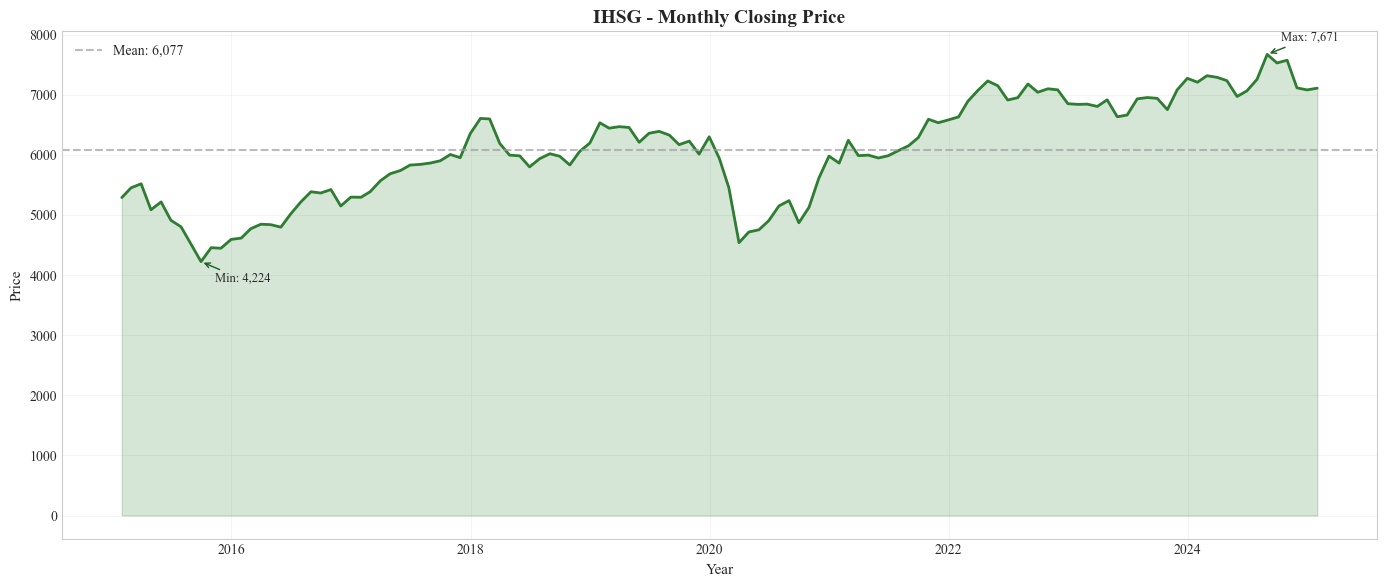

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_clean['Date'], df_clean['IHSG'], color=COLORS['IHSG'], linewidth=2)
ax.fill_between(df_clean['Date'], df_clean['IHSG'], alpha=0.2, color=COLORS['IHSG'])

# Add mean line
ihsg_mean = df_clean['IHSG'].mean()
ax.axhline(y=ihsg_mean, color=COLORS['error'], linestyle='--', alpha=0.7, 
           label=f'Mean: {ihsg_mean:,.0f}')

ax.set_title('IHSG - Monthly Closing Price', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add annotations for min/max
ihsg_max_idx = df_clean['IHSG'].idxmax()
ihsg_min_idx = df_clean['IHSG'].idxmin()
ax.annotate(f"Max: {df_clean.loc[ihsg_max_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_max_idx, 'Date'], df_clean.loc[ihsg_max_idx, 'IHSG']),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))
ax.annotate(f"Min: {df_clean.loc[ihsg_min_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_min_idx, 'Date'], df_clean.loc[ihsg_min_idx, 'IHSG']),
            xytext=(10, -15), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))

plt.tight_layout()
plt.savefig('model1-figure/eda_ihsg.png', dpi=300, bbox_inches='tight')
plt.show()

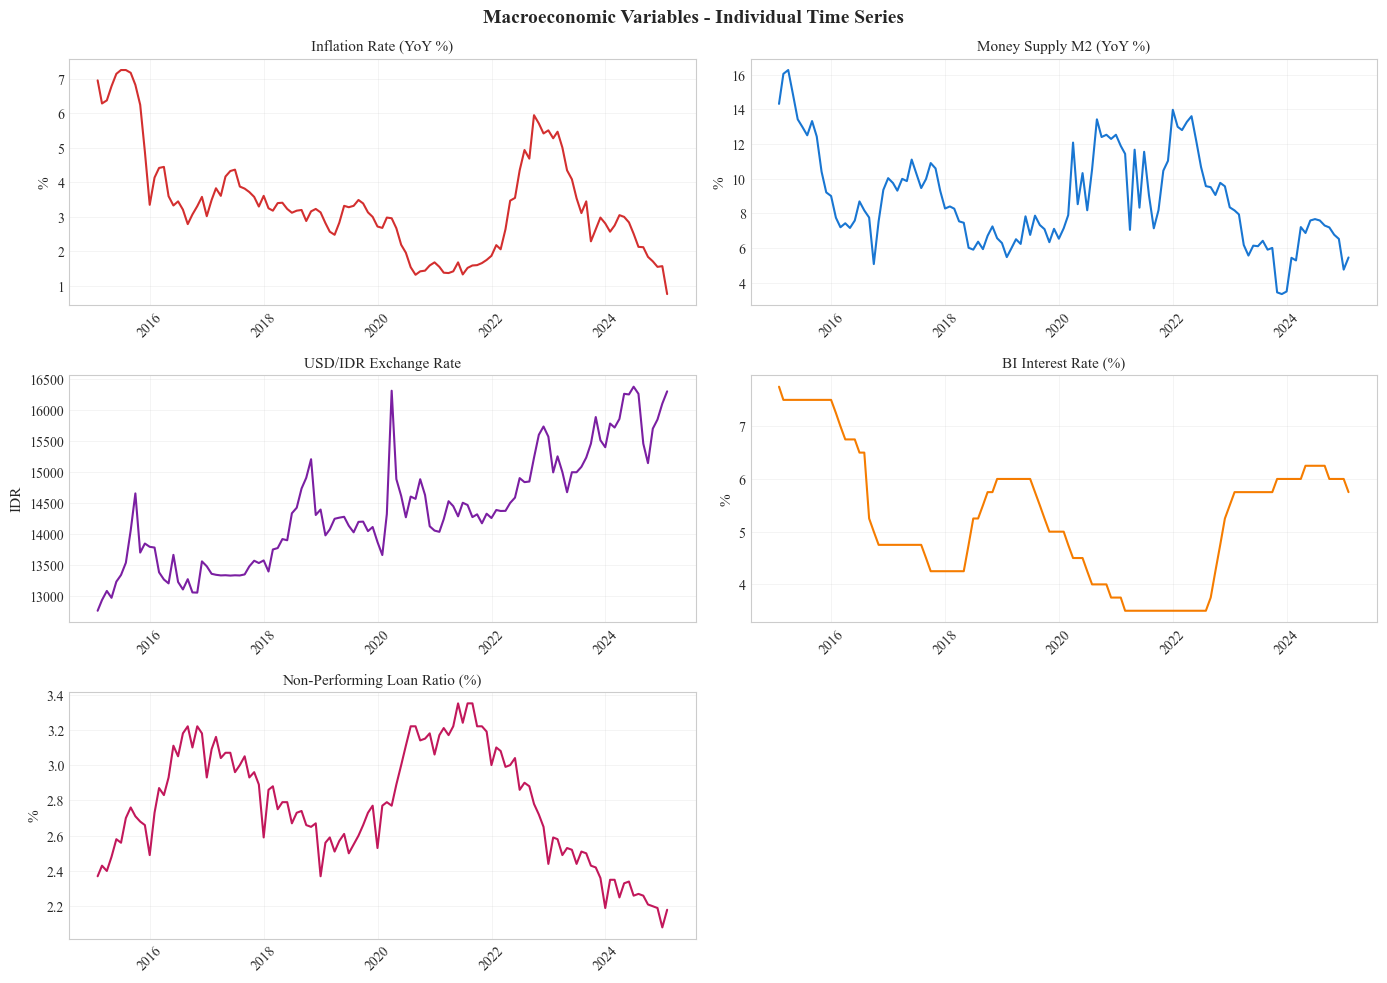

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Macroeconomic Variables - Individual Time Series', fontsize=14, fontweight='bold')

plot_config = [
    ('Inflation_YoY', COLORS['Inflation'], 'Inflation Rate (YoY %)', '%'),
    ('M2_YoY', COLORS['M2_YoY'], 'Money Supply M2 (YoY %)', '%'),
    ('USDIDR', COLORS['USDIDR'], 'USD/IDR Exchange Rate', 'IDR'),
    ('BI_Rate', COLORS['BI_Rate'], 'BI Interest Rate (%)', '%'),
    ('NPL_Ratio', COLORS['NPL_Ratio'], 'Non-Performing Loan Ratio (%)', '%'),
]

for idx, (col, color, title, ylabel) in enumerate(plot_config):
    ax = axes[idx // 2, idx % 2]
    ax.plot(df_clean['Date'], df_clean[col], color=color, linewidth=1.5)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Hide the last empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.savefig('model1-figure/eda_covariates_individual.png', dpi=300, bbox_inches='tight')
plt.show()

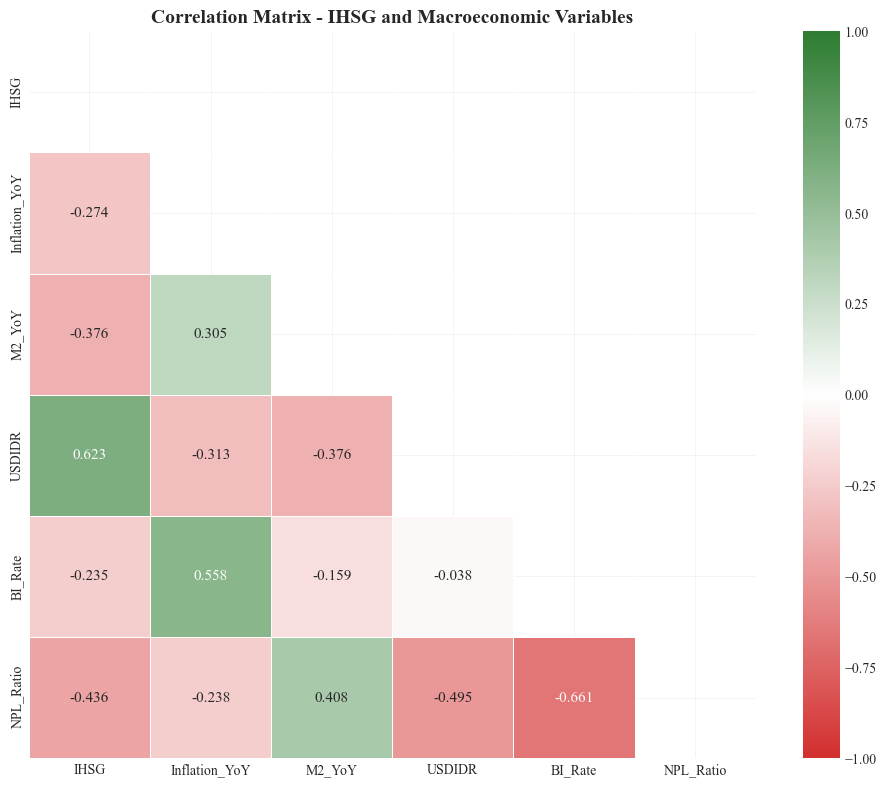

✅ Figure saved: model1-figure/correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
USDIDR          : +0.6227 (Moderate ↑ Positive)
BI_Rate         : -0.2353 (Weak ↓ Negative)
Inflation_YoY   : -0.2740 (Weak ↓ Negative)
M2_YoY          : -0.3763 (Weak ↓ Negative)
NPL_Ratio       : -0.4360 (Moderate ↓ Negative)


In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df_clean.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 11}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG and Macroeconomic Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model1-figure/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/correlation_matrix.png (300 DPI)")
print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "↑ Positive" if corr > 0 else "↓ Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## 5. Create Darts TimeSeries Objects

In [10]:
IHSG_series = TimeSeries.from_dataframe(df_clean, time_col='Date', value_cols='IHSG', freq='ME')
COVAR_series = TimeSeries.from_dataframe(df_clean, time_col='Date', value_cols=['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio'], freq='ME')

In [11]:
train_ratio = 0.8
split_point = int(len(IHSG_series) * train_ratio)

ihsg_train = IHSG_series[:split_point]
ihsg_test = IHSG_series[split_point:]

covar_train = COVAR_series[:split_point]
covar_test = COVAR_series[split_point:]

<Axes: xlabel='Date'>

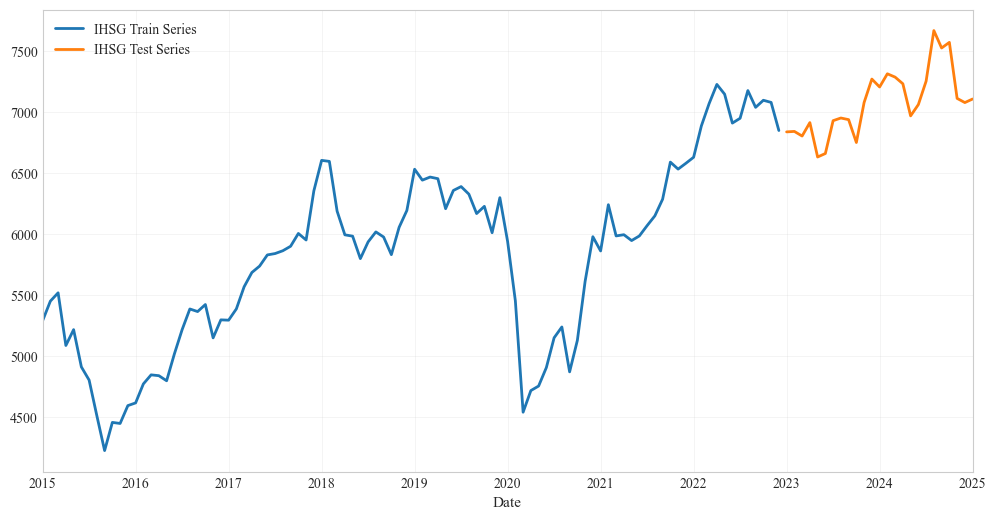

In [12]:
ihsg_train.plot(label='IHSG Train Series')
ihsg_test.plot(label='IHSG Test Series')

In [13]:
ihsg_train

,IHSG
Date,
2015-01-31,5289.404
2015-02-28,5450.294
2015-03-31,5518.675
2015-04-30,5086.425
2015-05-31,5216.379
...,...
2022-08-31,7178.590
2022-09-30,7040.798
2022-10-31,7098.890


In [14]:
print("DARTS TIMESERIES")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {IHSG_series.start_time()}")
print(f"  - End: {IHSG_series.end_time()}")
print(f"  - Length: {len(IHSG_series)} time steps")
print(f"  - Frequency: {IHSG_series.freq}")
print(f"\nCovariates:")
print(f"  - Components: {COVAR_series.components.tolist()}")
print(f"  - Length: {len(COVAR_series)} time steps")

DARTS TIMESERIES
Target Series (IHSG):
  - Start: 2015-01-31 00:00:00
  - End: 2025-01-31 00:00:00
  - Length: 121 time steps
  - Frequency: <MonthEnd>

Covariates:
  - Components: ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']
  - Length: 121 time steps


## train, test, split and normalization

In [15]:
from darts.dataprocessing.transformers import Scaler

scaler_ihsg = Scaler(MinMaxScaler(feature_range=(-1, 1)))

ihsg_train_scaled = scaler_ihsg.fit_transform(ihsg_train)
ihsg_test_scaled = scaler_ihsg.transform(ihsg_test)

scaler_covar = Scaler(MinMaxScaler(feature_range=(-1, 1)))

covar_train_scaled = scaler_covar.fit_transform(covar_train)
covar_test_scaled = scaler_covar.transform(covar_test)

covar_full_scaled = covar_train_scaled.append(covar_test_scaled)

# =====================================================
# VERIFIKASI TIDAK ADA LEAKAGE
# =====================================================
print("="*60)
print("DATA LEAKAGE CHECK")
print("="*60)
print(f"Train Target: {ihsg_train_scaled.start_time()} → {ihsg_train_scaled.end_time()}")
print(f"Train Cov:    {covar_train_scaled.start_time()} → {covar_train_scaled.end_time()}")
print(f"Test Target:  {ihsg_test_scaled.start_time()} → {ihsg_test_scaled.end_time()}")
print(f"Test Cov:     {covar_test_scaled.start_time()} → {covar_test_scaled.end_time()}")

# Pastikan train periods match
assert ihsg_train_scaled.end_time() == covar_train_scaled.end_time(), \
    "ERROR: Train target dan covariates tidak sinkron!"
print("\n✓ No data leakage detected in split")

DATA LEAKAGE CHECK
Train Target: 2015-01-31 00:00:00 → 2022-12-31 00:00:00
Train Cov:    2015-01-31 00:00:00 → 2022-12-31 00:00:00
Test Target:  2023-01-31 00:00:00 → 2025-01-31 00:00:00
Test Cov:     2023-01-31 00:00:00 → 2025-01-31 00:00:00

✓ No data leakage detected in split


## hyperparameter tuning

In [16]:
OUTPUT_CHUNK_LENGTH = 1

# hyperparameter tuning gridsearch

param_grid = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],       
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 7, None],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],        
}
    
print("\nGridSearch Parameters:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to evaluate: {total_combinations}")



GridSearch Parameters:
  lags: [1, 3, 6, 12]
  lags_past_covariates: [1, 3, 6, 12]
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7, None]
  max_features: [None, 'sqrt', 'log2']
  bootstrap: [True, False]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Total combinations to evaluate: 10368


In [17]:
best_model, best_params, best_score = RandomForestModel.gridsearch(
    parameters=param_grid,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 15.9250%

Best Hyperparameters:
  lags: 3
  lags_past_covariates: 3
  n_estimators: 100
  max_depth: 5
  max_features: None
  bootstrap: True
  min_samples_split: 2
  min_samples_leaf: 2


In [18]:
final_model = RandomForestModel(
    lags=best_params['lags'],
    lags_past_covariates=best_params['lags_past_covariates'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

In [19]:
final_model.fit(
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

RandomForestModel(lags=3, lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=5, multi_models=True, use_static_covariates=True, random_state=42, max_features=None, bootstrap=True, min_samples_split=2, min_samples_leaf=2, n_jobs=-1)

In [20]:
forecast = final_model.predict(
    n=len(ihsg_test_scaled),
    past_covariates=covar_full_scaled
)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [35]:
from darts.metrics import rmse, mae, mape, smape, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Inverse transform to original scale
forecast_original = scaler_ihsg.inverse_transform(forecast)
test_original = scaler_ihsg.inverse_transform(ihsg_test_scaled)

print("="*60)
print("MODEL PERFORMANCE METRICS (Original Scale)")
print("="*60)

# Calculate metrics
metrics = {
    'RMSE': rmse(test_original, forecast_original),
    'MAE': mae(test_original, forecast_original),
    'MAPE': mape(test_original, forecast_original),
    'sMAPE': smape(test_original, forecast_original),
    'R²': r2_score(test_original, forecast_original)
}

for metric, value in metrics.items():
    print(f"{metric:8s}: {value:.4f}")

MODEL PERFORMANCE METRICS (Original Scale)
RMSE    : 277.6745
MAE     : 222.1677
MAPE    : 3.0925
sMAPE   : 3.1312
R²      : -0.0881


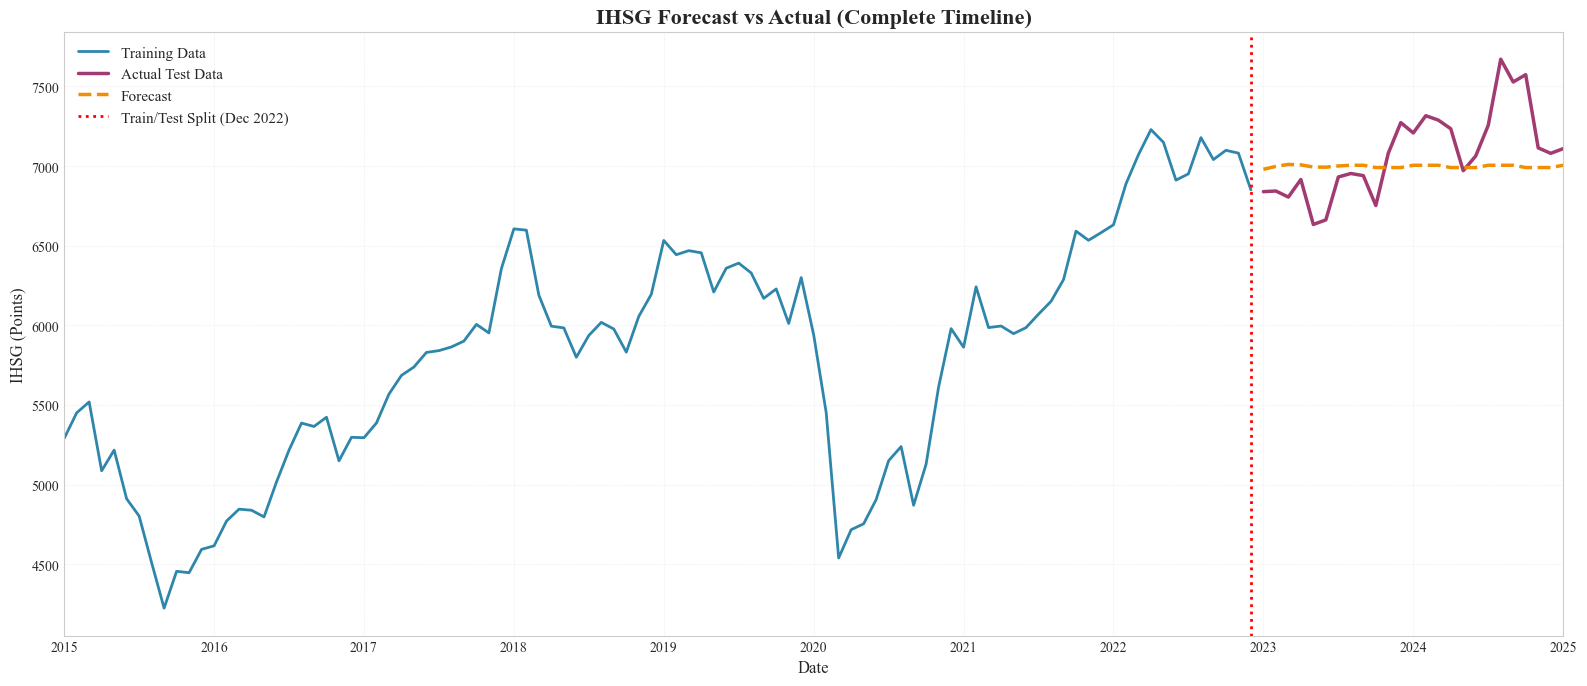

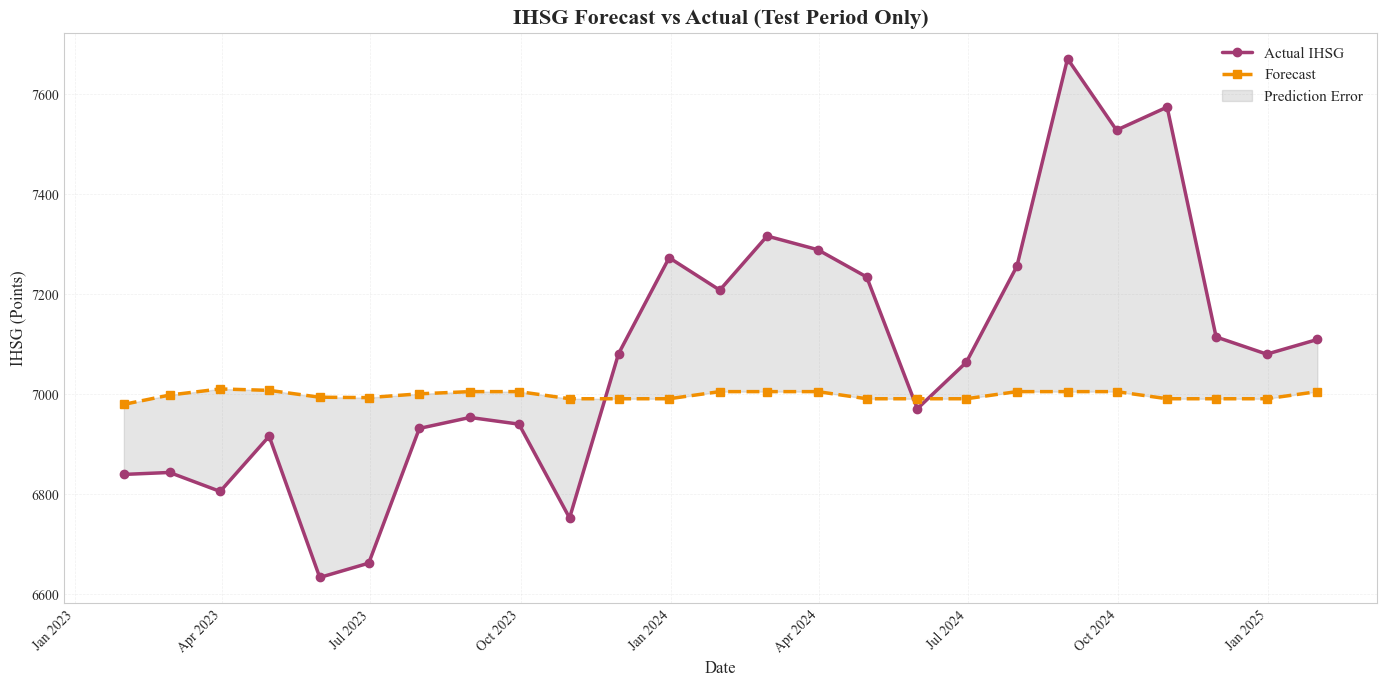

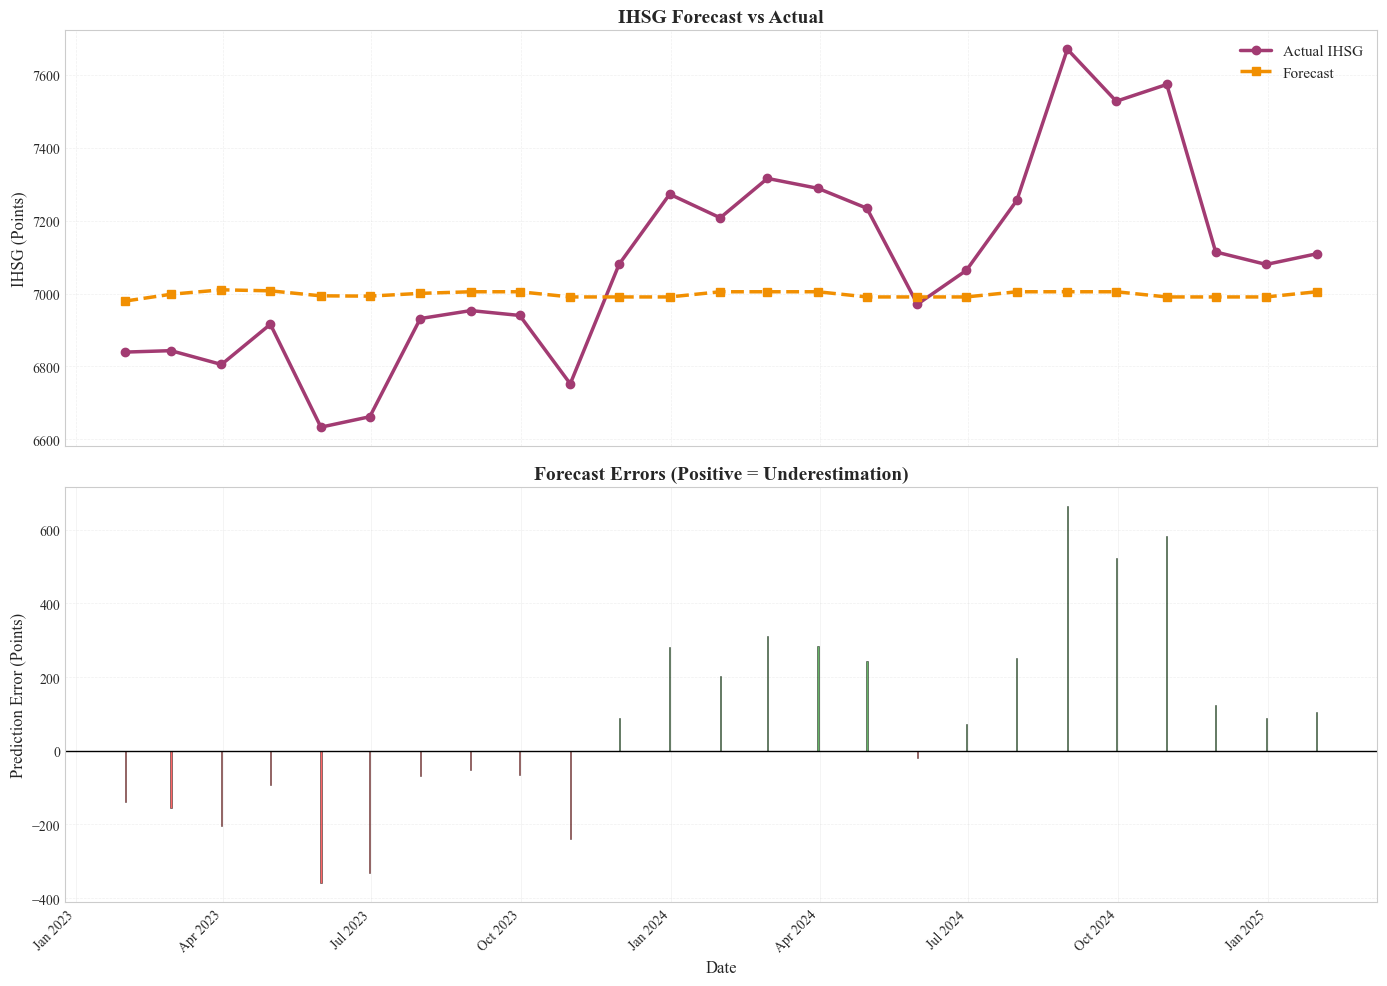

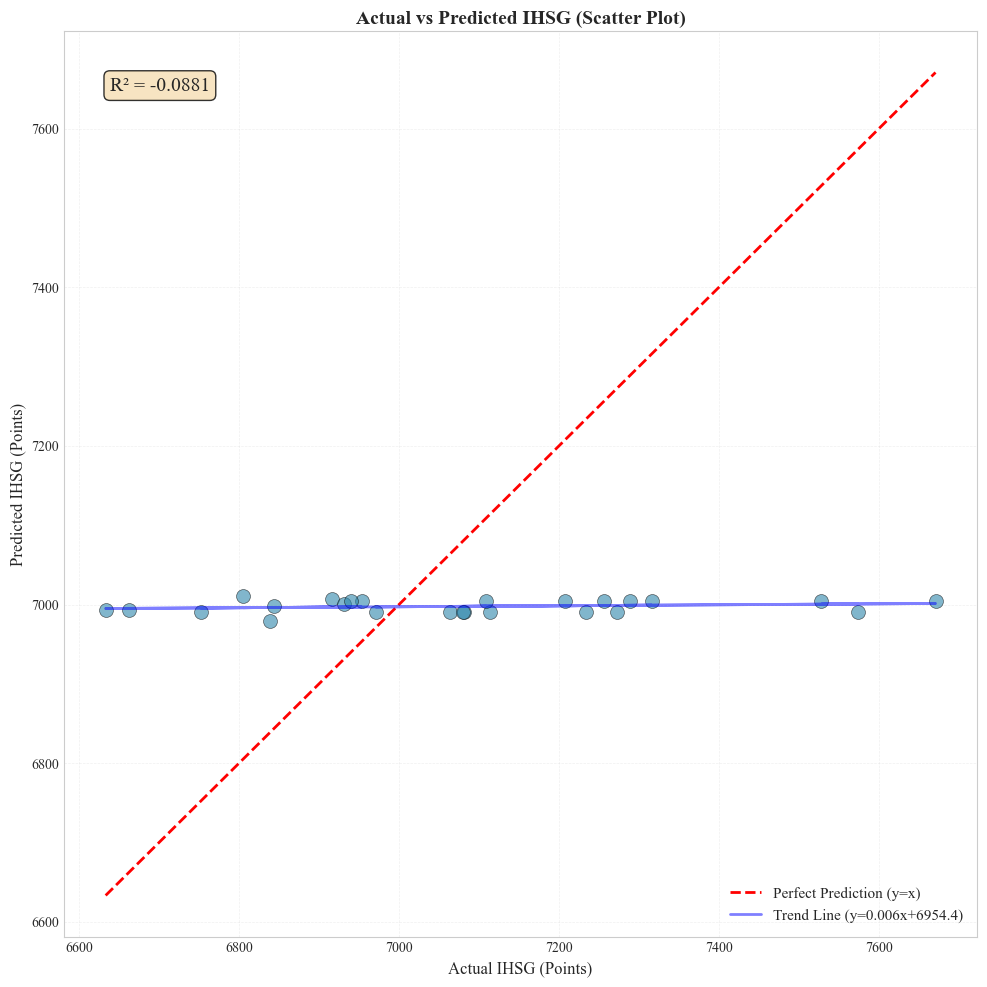

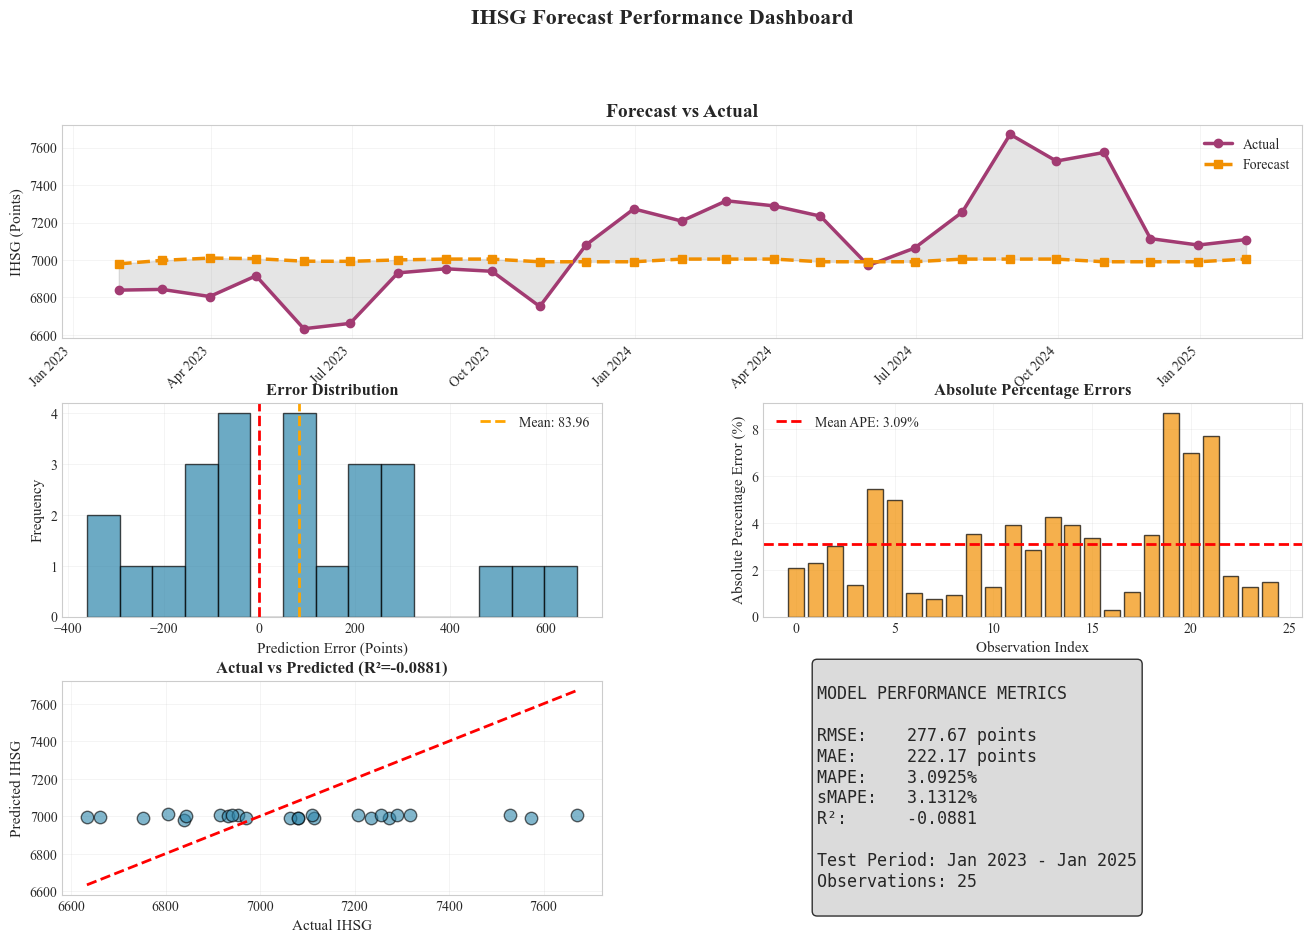


FORECAST SUMMARY STATISTICS
Test Period:        January 2023 to January 2025
Number of Points:   25

Actual IHSG:
  Mean:             7081.69
  Min:              6633.26
  Max:              7670.73
  Std Dev:          266.19

Forecast IHSG:
  Mean:             6997.72
  Min:              6979.46
  Max:              7010.30
  Std Dev:          7.87

Prediction Errors:
  Mean Error:       83.96 points
  Mean Abs Error:   222.17 points
  Max Overest:      -360.46 points
  Max Underest:     665.79 points


In [38]:
# =====================================================
# FORECAST VS ACTUAL VISUALIZATION (Original Scale)
# =====================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Ensure we have the data
forecast_original = scaler_ihsg.inverse_transform(forecast)
test_original = scaler_ihsg.inverse_transform(ihsg_test_scaled)
train_original = scaler_ihsg.inverse_transform(ihsg_train_scaled)

# =====================================================
# PLOT 1: Complete Timeline with Train/Test/Forecast
# =====================================================
plt.figure(figsize=(16, 7))

# Plot train data
train_original.plot(label="Training Data", color='#2E86AB', linewidth=2)

# Plot actual test data
test_original.plot(label="Actual Test Data", color='#A23B72', linewidth=2.5)

# Plot forecast
forecast_original.plot(label="Forecast", color='#F18F01', linewidth=2.5, linestyle='--')

# Add vertical line at train/test split
split_date = train_original.end_time()
plt.axvline(x=split_date, color='red', linestyle=':', linewidth=2, 
            label=f'Train/Test Split ({split_date.strftime("%b %Y")})')

# Formatting
plt.title('IHSG Forecast vs Actual (Complete Timeline)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# =====================================================
# PLOT 2: Test Period Only (Zoomed In)
# =====================================================
plt.figure(figsize=(14, 7))

# Plot actual and forecast
test_dates = test_original.time_index
actual_values = test_original.values().flatten()
forecast_values = forecast_original.values().flatten()

plt.plot(test_dates, actual_values, marker='o', markersize=6, 
         linewidth=2.5, color='#A23B72', label='Actual IHSG', linestyle='-')
plt.plot(test_dates, forecast_values, marker='s', markersize=6, 
         linewidth=2.5, color='#F18F01', label='Forecast', linestyle='--')

# Fill between to show error
plt.fill_between(test_dates, actual_values, forecast_values, 
                 alpha=0.2, color='gray', label='Prediction Error')

# Formatting
plt.title('IHSG Forecast vs Actual (Test Period Only)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# PLOT 3: Side-by-Side Comparison with Error Bars
# =====================================================
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Subplot 1: Actual vs Forecast
axes[0].plot(test_dates, actual_values, marker='o', markersize=6,
             linewidth=2.5, color='#A23B72', label='Actual IHSG')
axes[0].plot(test_dates, forecast_values, marker='s', markersize=6,
             linewidth=2.5, color='#F18F01', label='Forecast', linestyle='--')
axes[0].set_ylabel('IHSG (Points)', fontsize=12)
axes[0].set_title('IHSG Forecast vs Actual', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Subplot 2: Absolute Errors
errors = actual_values - forecast_values
axes[1].bar(test_dates, errors, color=['green' if e > 0 else 'red' for e in errors],
            alpha=0.6, edgecolor='black', linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_ylabel('Prediction Error (Points)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_title('Forecast Errors (Positive = Underestimation)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')

# Format x-axis
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# PLOT 4: Scatter Plot (Actual vs Predicted)
# =====================================================
plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(actual_values, forecast_values, alpha=0.6, s=100, 
            color='#2E86AB', edgecolors='black', linewidth=0.5)

# Perfect prediction line (y=x)
min_val = min(actual_values.min(), forecast_values.min())
max_val = max(actual_values.max(), forecast_values.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
         label='Perfect Prediction (y=x)')

# Add trend line
z = np.polyfit(actual_values, forecast_values, 1)
p = np.poly1d(z)
plt.plot(actual_values, p(actual_values), "b-", linewidth=2, alpha=0.5,
         label=f'Trend Line (y={z[0]:.3f}x+{z[1]:.1f})')

# Add R² annotation
from sklearn.metrics import r2_score as sklearn_r2
r2 = sklearn_r2(actual_values, forecast_values)
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.8))

# Formatting
plt.xlabel('Actual IHSG (Points)', fontsize=12)
plt.ylabel('Predicted IHSG (Points)', fontsize=12)
plt.title('Actual vs Predicted IHSG (Scatter Plot)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# =====================================================
# PLOT 5: Performance Summary Dashboard
# =====================================================
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Time Series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_dates, actual_values, marker='o', linewidth=2.5, 
         color='#A23B72', label='Actual')
ax1.plot(test_dates, forecast_values, marker='s', linewidth=2.5, 
         color='#F18F01', label='Forecast', linestyle='--')
ax1.fill_between(test_dates, actual_values, forecast_values, 
                 alpha=0.2, color='gray')
ax1.set_title('Forecast vs Actual', fontsize=14, fontweight='bold')
ax1.set_ylabel('IHSG (Points)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Error Distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(errors, bins=15, edgecolor='black', alpha=0.7, color='#2E86AB')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2,
            label=f'Mean: {errors.mean():.2f}')
ax2.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Prediction Error (Points)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Absolute Percentage Errors
ax3 = fig.add_subplot(gs[1, 1])
percentage_errors = np.abs(errors / actual_values) * 100
ax3.bar(range(len(percentage_errors)), percentage_errors, 
        color='#F18F01', alpha=0.7, edgecolor='black')
ax3.axhline(y=percentage_errors.mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean APE: {percentage_errors.mean():.2f}%')
ax3.set_title('Absolute Percentage Errors', fontsize=12, fontweight='bold')
ax3.set_xlabel('Observation Index')
ax3.set_ylabel('Absolute Percentage Error (%)')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Scatter Plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(actual_values, forecast_values, alpha=0.6, s=80, 
            color='#2E86AB', edgecolors='black')
min_val = min(actual_values.min(), forecast_values.min())
max_val = max(actual_values.max(), forecast_values.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax4.set_title(f'Actual vs Predicted (R²={r2:.4f})', fontsize=12, fontweight='bold')
ax4.set_xlabel('Actual IHSG')
ax4.set_ylabel('Predicted IHSG')
ax4.grid(True, alpha=0.3)

# Plot 5: Metrics Table
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

# Calculate metrics
from darts.metrics import rmse, mae, mape, smape
metrics_text = f"""
MODEL PERFORMANCE METRICS

RMSE:    {rmse(test_original, forecast_original):.2f} points
MAE:     {mae(test_original, forecast_original):.2f} points
MAPE:    {mape(test_original, forecast_original):.4f}%
sMAPE:   {smape(test_original, forecast_original):.4f}%
R²:      {r2:.4f}

Test Period: {test_dates[0].strftime('%b %Y')} - {test_dates[-1].strftime('%b %Y')}
Observations: {len(test_dates)}
"""

ax5.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', 
         facecolor='lightgray', alpha=0.8))

plt.suptitle('IHSG Forecast Performance Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================
# Print Summary Statistics
# =====================================================
print("\n" + "="*70)
print("FORECAST SUMMARY STATISTICS")
print("="*70)
print(f"Test Period:        {test_dates[0].strftime('%B %Y')} to {test_dates[-1].strftime('%B %Y')}")
print(f"Number of Points:   {len(test_dates)}")
print(f"\nActual IHSG:")
print(f"  Mean:             {actual_values.mean():.2f}")
print(f"  Min:              {actual_values.min():.2f}")
print(f"  Max:              {actual_values.max():.2f}")
print(f"  Std Dev:          {actual_values.std():.2f}")
print(f"\nForecast IHSG:")
print(f"  Mean:             {forecast_values.mean():.2f}")
print(f"  Min:              {forecast_values.min():.2f}")
print(f"  Max:              {forecast_values.max():.2f}")
print(f"  Std Dev:          {forecast_values.std():.2f}")
print(f"\nPrediction Errors:")
print(f"  Mean Error:       {errors.mean():.2f} points")
print(f"  Mean Abs Error:   {np.abs(errors).mean():.2f} points")
print(f"  Max Overest:      {errors.min():.2f} points")
print(f"  Max Underest:     {errors.max():.2f} points")

INITIALIZING SHAP EXPLAINER
✓ SHAP Explainer initialized
  Background samples: 50
  Method: TreeExplainer (optimized for Random Forest)

GENERATING SHAP EXPLANATIONS FOR TEST DATA
✓ Explanations generated successfully

GENERATING SHAP SUMMARY PLOTS


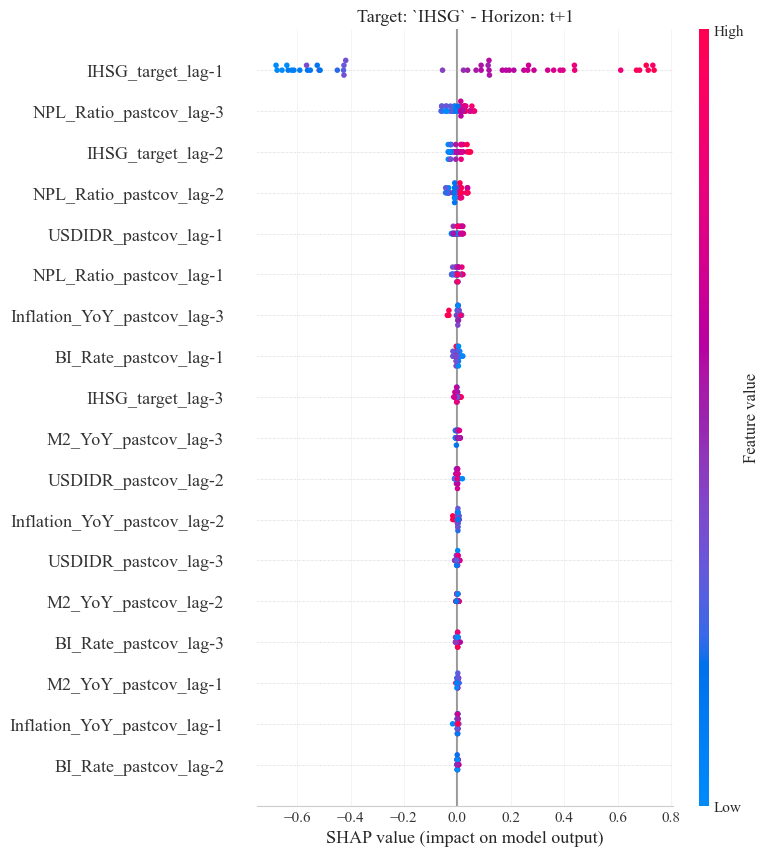

<Figure size 1200x600 with 0 Axes>

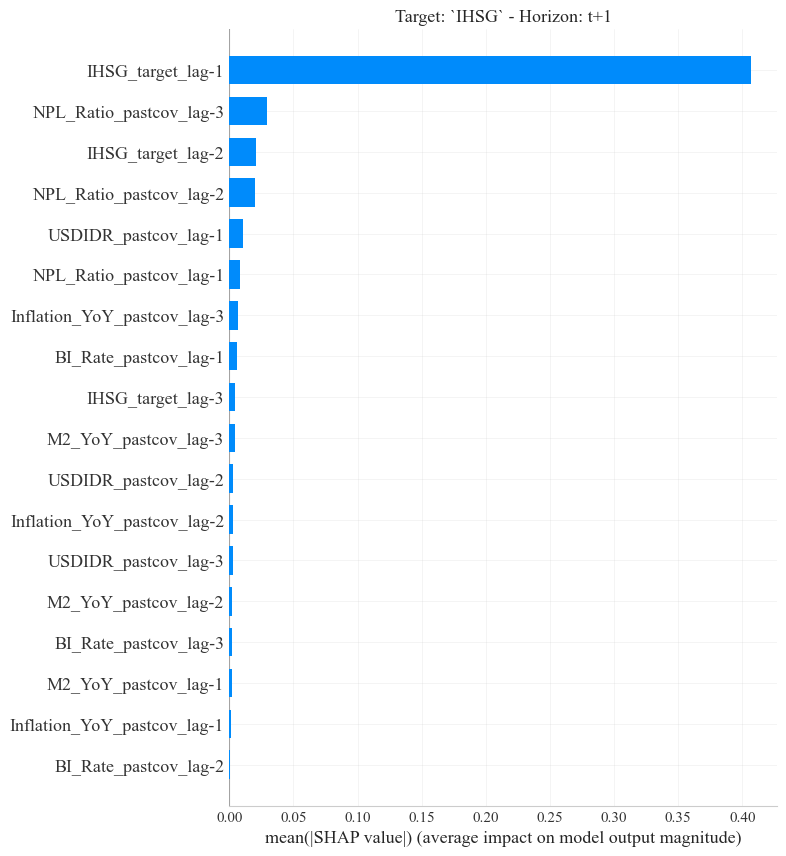

<Figure size 1200x600 with 0 Axes>


EXTRACTING SHAP VALUES FOR ANALYSIS
Explanation TimeSeries shape: (23, 18)
Feature values shape: (23, 18)
Feature names: Index(['IHSG_target_lag-3', 'IHSG_target_lag-2', 'IHSG_target_lag-1',
       'Inflation_YoY_pastcov_lag-3', 'M2_YoY_pastcov_lag-3',
       'USDIDR_pastcov_lag-3', 'BI_Rate_pastcov_lag-3',
       'NPL_Ratio_pastcov_lag-3', 'Inflation_YoY_pastcov_lag-2',
       'M2_YoY_pastcov_lag-2', 'USDIDR_pastcov_lag-2', 'BI_Rate_pastcov_lag-2',
       'NPL_Ratio_pastcov_lag-2', 'Inflation_YoY_pastcov_lag-1',
       'M2_YoY_pastcov_lag-1', 'USDIDR_pastcov_lag-1', 'BI_Rate_pastcov_lag-1',
       'NPL_Ratio_pastcov_lag-1'],
      dtype='object')

Total features: 18

TOP 15 MOST IMPORTANT FEATURES (by Mean |SHAP|)
                    Feature  Mean_Abs_SHAP
          IHSG_target_lag-1       0.720058
          IHSG_target_lag-2       0.043895
       USDIDR_pastcov_lag-1       0.023234
    NPL_Ratio_pastcov_lag-3       0.014380
          IHSG_target_lag-3       0.009924
    NPL_Ratio_pa

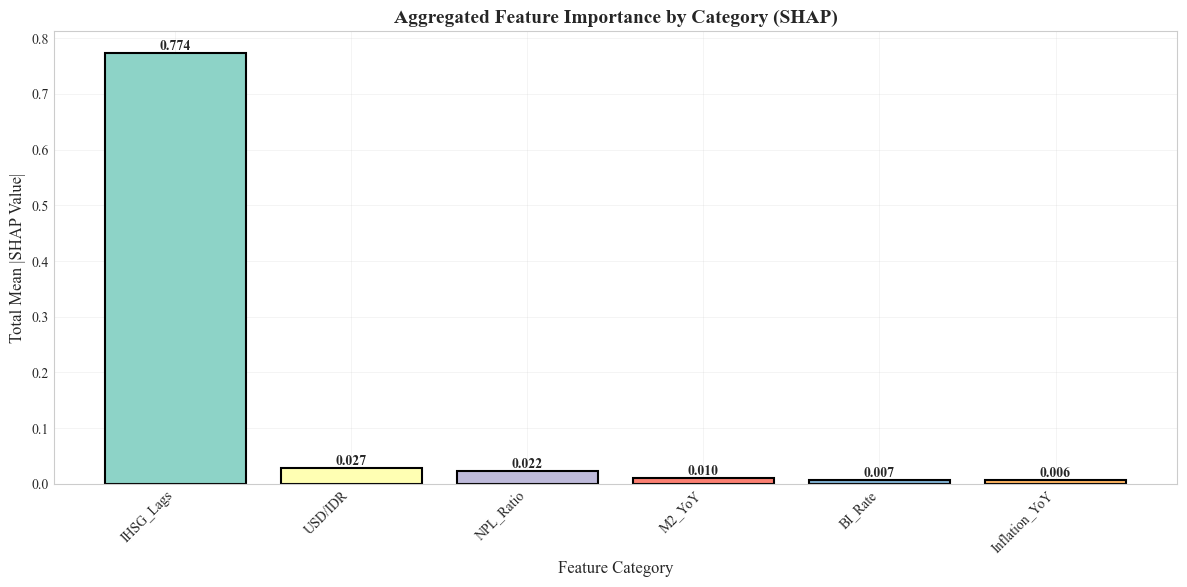


TOP 18 FEATURES VISUALIZATION


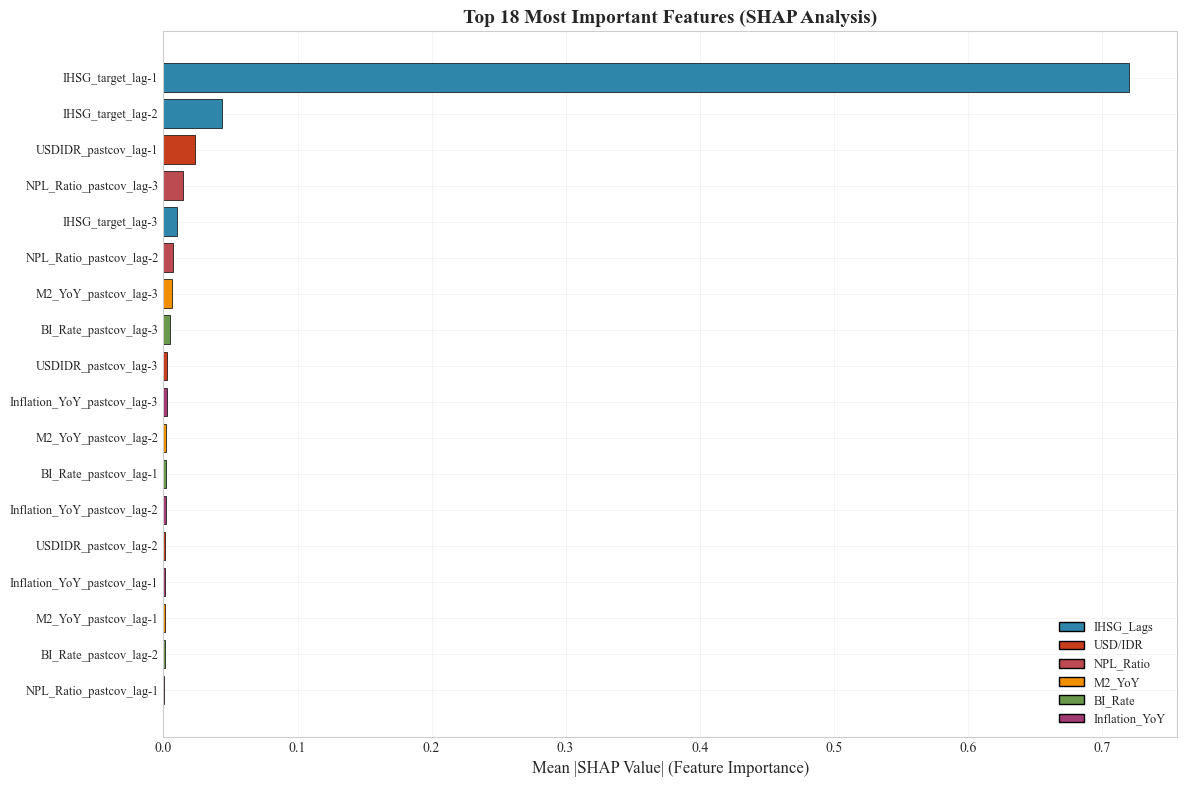


GENERATING FORCE PLOT (Interactive)
Force plot shows how each feature pushes prediction up or down
for a specific time point.

ANALYZING SHAP VALUES OVER TIME
Available timestamps: 23
Date range: Jan 2023 to Nov 2024


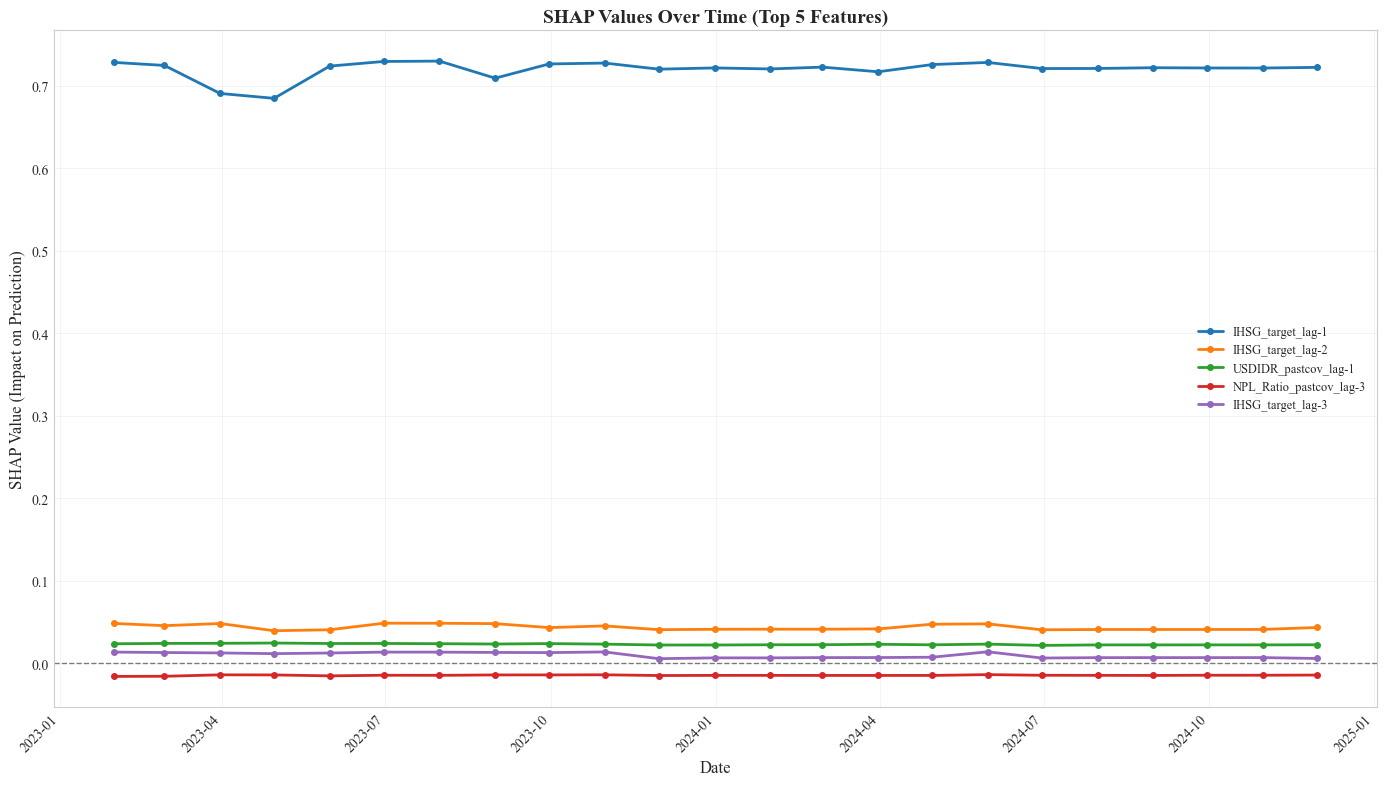


DETAILED STATISTICS BY COVARIATE TYPE

IHSG_Lags:
  Total importance: 0.7739
  Number of lags:   3
  Mean per lag:     0.2580
  Top lags:
    - IHSG_target_lag-1                        : 0.7201
    - IHSG_target_lag-2                        : 0.0439
    - IHSG_target_lag-3                        : 0.0099

USD/IDR:
  Total importance: 0.0275
  Number of lags:   3
  Mean per lag:     0.0092
  Top lags:
    - USDIDR_pastcov_lag-1                     : 0.0232
    - USDIDR_pastcov_lag-3                     : 0.0029
    - USDIDR_pastcov_lag-2                     : 0.0013

NPL_Ratio:
  Total importance: 0.0223
  Number of lags:   3
  Mean per lag:     0.0074
  Top lags:
    - NPL_Ratio_pastcov_lag-3                  : 0.0144
    - NPL_Ratio_pastcov_lag-2                  : 0.0071
    - NPL_Ratio_pastcov_lag-1                  : 0.0007

M2_YoY:
  Total importance: 0.0097
  Number of lags:   3
  Mean per lag:     0.0032
  Top lags:
    - M2_YoY_pastcov_lag-3                     : 0.0065
    - 

In [42]:
# =====================================================
# SHAP EXPLAINER ANALYSIS (CORRECTED VERSION)
# =====================================================
from darts.explainability.shap_explainer import ShapExplainer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("INITIALIZING SHAP EXPLAINER")
print("="*70)

# =====================================================
# 1. INITIALIZE SHAP EXPLAINER
# =====================================================
shap_explainer = ShapExplainer(
    model=final_model,
    background_series=ihsg_train_scaled,
    background_past_covariates=covar_train_scaled,
    background_num_samples=50,
    shap_method='tree'
)

print("✓ SHAP Explainer initialized")
print(f"  Background samples: 50")
print(f"  Method: TreeExplainer (optimized for Random Forest)")

# =====================================================
# 2. EXPLAIN TEST DATA
# =====================================================
print("\n" + "="*70)
print("GENERATING SHAP EXPLANATIONS FOR TEST DATA")
print("="*70)

explain_results = shap_explainer.explain(
    foreground_series=ihsg_test_scaled,
    foreground_past_covariates=covar_test_scaled,
    horizons=[1],
    target_components=['IHSG']
)

print("✓ Explanations generated successfully")

# =====================================================
# 3. SUMMARY PLOT (MAIN FEATURE IMPORTANCE)
# =====================================================
print("\n" + "="*70)
print("GENERATING SHAP SUMMARY PLOTS")
print("="*70)

# Summary plot - Dot plot
plt.figure(figsize=(12, 8))
shap_explainer.summary_plot(
    horizons=[1],
    target_components=['IHSG'],
    plot_type='dot'
)
plt.tight_layout()
plt.show()

# Summary plot - Bar plot
plt.figure(figsize=(12, 8))
shap_explainer.summary_plot(
    horizons=[1],
    target_components=['IHSG'],
    plot_type='bar'
)
plt.tight_layout()
plt.show()

# =====================================================
# 4. EXTRACT SHAP VALUES FOR CUSTOM ANALYSIS
# =====================================================
print("\n" + "="*70)
print("EXTRACTING SHAP VALUES FOR ANALYSIS")
print("="*70)

# Get explanation time series
shap_explanation_ts = explain_results.get_explanation(horizon=1, component='IHSG')

# Get feature values
feature_values = explain_results.get_feature_values(horizon=1, component='IHSG')

# ❌ REMOVED THIS LINE - METHOD DOESN'T EXIST:
# shap_objects = explain_results.get_shap_explanation_objects(horizon=1, component='IHSG')

print(f"Explanation TimeSeries shape: {shap_explanation_ts.values().shape}")
print(f"Feature values shape: {feature_values.values().shape}")
print(f"Feature names: {shap_explanation_ts.components}")
print(f"\nTotal features: {len(shap_explanation_ts.components)}")

# =====================================================
# 5. FEATURE IMPORTANCE AGGREGATION
# =====================================================
shap_values_array = shap_explanation_ts.values()
feature_names = shap_explanation_ts.components

# Calculate mean absolute SHAP value for each feature
mean_abs_shap = np.mean(np.abs(shap_values_array), axis=0)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\n" + "="*70)
print("TOP 15 MOST IMPORTANT FEATURES (by Mean |SHAP|)")
print("="*70)
print(feature_importance_df.head(15).to_string(index=False))

# =====================================================
# 6. GROUP FEATURES BY TYPE
# =====================================================
def categorize_feature(feature_name):
    """Categorize features into groups"""
    if 'target_lag' in feature_name:
        return 'IHSG_Lags'
    elif 'Inflation' in feature_name:
        return 'Inflation_YoY'
    elif 'M2' in feature_name:
        return 'M2_YoY'
    elif 'USDIDR' in feature_name:
        return 'USD/IDR'
    elif 'BI_Rate' in feature_name:
        return 'BI_Rate'
    elif 'NPL' in feature_name:
        return 'NPL_Ratio'
    else:
        return 'Other'

feature_importance_df['Category'] = feature_importance_df['Feature'].apply(categorize_feature)

# Aggregate by category
category_importance = feature_importance_df.groupby('Category')['Mean_Abs_SHAP'].sum().sort_values(ascending=False)

print("\n" + "="*70)
print("FEATURE IMPORTANCE BY CATEGORY (Aggregated)")
print("="*70)
for category, importance in category_importance.items():
    count = len(feature_importance_df[feature_importance_df['Category'] == category])
    pct = (importance / category_importance.sum()) * 100
    print(f"{category:<20}: {importance:>8.4f} ({pct:>5.2f}%) - {count} features")

# Visualize category importance
plt.figure(figsize=(12, 6))
colors = plt.cm.Set3(range(len(category_importance)))
bars = plt.bar(category_importance.index, category_importance.values, 
               color=colors, edgecolor='black', linewidth=1.5)
plt.title('Aggregated Feature Importance by Category (SHAP)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Feature Category', fontsize=12)
plt.ylabel('Total Mean |SHAP Value|', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# =====================================================
# 7. TOP FEATURES VISUALIZATION (FIXED)
# =====================================================
# Handle case where we have fewer features than requested
requested_top_n = 20
total_features = len(feature_importance_df)
actual_top_n = min(requested_top_n, total_features)

print(f"\n" + "="*70)
print(f"TOP {actual_top_n} FEATURES VISUALIZATION")
print("="*70)

top_features = feature_importance_df.head(actual_top_n).copy()

plt.figure(figsize=(12, max(8, actual_top_n * 0.4)))

colors_map = {
    'IHSG_Lags': '#2E86AB',
    'Inflation_YoY': '#A23B72',
    'M2_YoY': '#F18F01',
    'USD/IDR': '#C73E1D',
    'BI_Rate': '#6A994E',
    'NPL_Ratio': '#BC4B51',
    'Other': '#8B8C89'
}

# Use .get() to handle missing categories
bar_colors = [colors_map.get(cat, '#8B8C89') for cat in top_features['Category']]

# Use actual_top_n for consistent dimensions
y_positions = range(actual_top_n)
plt.barh(y_positions, top_features['Mean_Abs_SHAP'].values, 
         color=bar_colors, edgecolor='black', linewidth=0.5)
plt.yticks(y_positions, top_features['Feature'].values, fontsize=9)
plt.xlabel('Mean |SHAP Value| (Feature Importance)', fontsize=12)
plt.title(f'Top {actual_top_n} Most Important Features (SHAP Analysis)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add legend only for categories that appear in top features
unique_categories = top_features['Category'].unique()
legend_elements = [Patch(facecolor=colors_map.get(cat, '#8B8C89'), 
                        edgecolor='black', label=cat) 
                   for cat in unique_categories]
plt.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

# =====================================================
# 8. FORCE PLOT FOR SPECIFIC TIME POINT
# =====================================================
print("\n" + "="*70)
print("GENERATING FORCE PLOT (Interactive)")
print("="*70)
print("Force plot shows how each feature pushes prediction up or down")
print("for a specific time point.")

try:
    shap_explainer.force_plot_from_ts(
        foreground_series=ihsg_test_scaled,
        foreground_past_covariates=covar_test_scaled,
        horizon=1,
        target_component='IHSG'
    )
except Exception as e:
    print(f"Note: Force plot may not display in all environments")
    print(f"Error: {e}")

# =====================================================
# 9. TEMPORAL ANALYSIS: SHAP VALUES OVER TIME
# =====================================================
print("\n" + "="*70)
print("ANALYZING SHAP VALUES OVER TIME")
print("="*70)

# Get available timestamps (accounting for lags)
available_timestamps = len(shap_values_array)
test_dates = ihsg_test_scaled.time_index[:available_timestamps]

print(f"Available timestamps: {available_timestamps}")
print(f"Date range: {test_dates[0].strftime('%b %Y')} to {test_dates[-1].strftime('%b %Y')}")

# Select top 5 features for visualization
top_5_features = feature_importance_df.head(5)['Feature'].tolist()
top_5_indices = [list(feature_names).index(feat) for feat in top_5_features]

plt.figure(figsize=(14, 8))
for idx, feat_name in zip(top_5_indices, top_5_features):
    shap_values_over_time = shap_values_array[:, idx]
    plt.plot(test_dates, shap_values_over_time, 
             marker='o', label=feat_name, linewidth=2, markersize=4)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.title('SHAP Values Over Time (Top 5 Features)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('SHAP Value (Impact on Prediction)', fontsize=12)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =====================================================
# 10. DETAILED STATISTICS BY COVARIATE
# =====================================================
print("\n" + "="*70)
print("DETAILED STATISTICS BY COVARIATE TYPE")
print("="*70)

for category in category_importance.index:
    if category == 'Other':
        continue
    
    category_features = feature_importance_df[feature_importance_df['Category'] == category]
    
    print(f"\n{category}:")
    print(f"  Total importance: {category_features['Mean_Abs_SHAP'].sum():.4f}")
    print(f"  Number of lags:   {len(category_features)}")
    print(f"  Mean per lag:     {category_features['Mean_Abs_SHAP'].mean():.4f}")
    print(f"  Top lags:")
    for idx, row in category_features.head(3).iterrows():
        print(f"    - {row['Feature']:<40} : {row['Mean_Abs_SHAP']:.4f}")

# =====================================================
# 11. SAVE RESULTS FOR THESIS
# =====================================================
# Save feature importance to CSV
feature_importance_df.to_csv('shap_feature_importance.csv', index=False)
category_importance.to_csv('shap_category_importance.csv')

# Save SHAP values time series
shap_df = pd.DataFrame(
    shap_values_array,
    index=test_dates,
    columns=feature_names
)
shap_df.to_csv('shap_values_timeseries.csv')

# Save feature values time series
feature_values_df = pd.DataFrame(
    feature_values.values(),
    index=test_dates,
    columns=feature_names
)
feature_values_df.to_csv('feature_values_timeseries.csv')

print("\n" + "="*70)
print("RESULTS SAVED")
print("="*70)
print("✓ shap_feature_importance.csv")
print("✓ shap_category_importance.csv")
print("✓ shap_values_timeseries.csv")
print("✓ feature_values_timeseries.csv")

# =====================================================
# 12. SUMMARY REPORT
# =====================================================
print("\n" + "="*70)
print("SHAP ANALYSIS SUMMARY REPORT")
print("="*70)

print(f"\nModel Configuration:")
print(f"  Lags (target):           {best_params['lags']}")
print(f"  Lags (past covariates):  {best_params['lags_past_covariates']}")
print(f"  Total features:          {len(feature_names)}")

print(f"\nData:")
print(f"  Explainable timestamps:  {available_timestamps}")
print(f"  Test period:             {test_dates[0].strftime('%b %Y')} to {test_dates[-1].strftime('%b %Y')}")

print(f"\nTop 5 Most Important Features:")
for i, row in enumerate(feature_importance_df.head(5).itertuples(), 1):
    print(f"  {i}. {row.Feature:<40} : {row.Mean_Abs_SHAP:.4f} ({row.Category})")

print(f"\nCategory Ranking:")
for i, (category, importance) in enumerate(category_importance.items(), 1):
    pct = (importance / category_importance.sum()) * 100
    print(f"  {i}. {category:<20} : {pct:>5.2f}%")

print("\n" + "="*70)
print("SHAP ANALYSIS COMPLETE!")
print("="*70)

## 10. Feature Importance with SHAP

In [118]:
# Final Summary
print("="*70)
print("HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI")
print("="*70)

print("\n📊 DATA:")
print(f"   • Periode Data     : {df_clean['Date'].min().strftime('%B %Y')} - {df_clean['Date'].max().strftime('%B %Y')}")
print(f"   • Total Observasi  : {len(df_clean)} bulan")
print(f"   • Train/Test Split : {train_ratio*100:.0f}% / {(1-train_ratio)*100:.0f}%")

print("\n🎯 TARGET:")
print(f"   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)")

print("\n📈 COVARIATES (Variabel Makroekonomi):")
for i, col in enumerate(COVARIATE_COLS, 1):
    print(f"   {i}. {col}")

print("\n⚙️ BEST HYPERPARAMETERS (via GridSearch):")
for param, value in best_params.items():
    print(f"   • {param}: {value}")

print("\n📏 MODEL PERFORMANCE:")
print(f"   • MAPE  : {mape_score:.4f}%")
print(f"   • RMSE  : {rmse_score:.4f}")
print(f"   • MAE   : {mae_score:.4f}")
print(f"   • R²    : {r2:.4f}")

print("\n🔍 FEATURE IMPORTANCE (SHAP - Top 3):")
for i, (var, imp) in enumerate(list(sorted_importance.items())[:3], 1):
    pct = (imp / total_importance) * 100
    print(f"   {i}. {var}: {pct:.2f}%")

print("\n" + "="*70)
print("Source: Author's calculation, 2025")
print("="*70)

HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI

📊 DATA:
   • Periode Data     : January 2015 - January 2025
   • Total Observasi  : 121 bulan
   • Train/Test Split : 80% / 20%

🎯 TARGET:
   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)

📈 COVARIATES (Variabel Makroekonomi):
   1. Inflation_YoY
   2. M2_YoY
   3. USDIDR
   4. BI_Rate
   5. NPL_Ratio

⚙️ BEST HYPERPARAMETERS (via GridSearch):
   • lags: 6
   • lags_past_covariates: 3
   • n_estimators: 200
   • max_depth: 5
   • max_features: None
   • bootstrap: True
   • min_samples_split: 5
   • min_samples_leaf: 4

📏 MODEL PERFORMANCE:
   • MAPE  : 1.1443%
   • RMSE  : 105.7583
   • MAE   : 81.9661
   • R²    : 0.8422

🔍 FEATURE IMPORTANCE (SHAP - Top 3):
   1. IHSG: 77.61%
   2. NPL_Ratio: 11.57%
   3. Inflation_YoY: 4.22%

Source: Author's calculation, 2025


In [119]:
# Save results to CSV
results_df = pd.DataFrame({
    'Date': test_actual.time_index,
    'Actual_IHSG': test_actual.values().flatten(),
    'Predicted_IHSG': predictions.values().flatten(),
    'Error': (predictions.values().flatten() - test_actual.values().flatten()),
    'APE_%': np.abs((predictions.values().flatten() - test_actual.values().flatten()) / test_actual.values().flatten()) * 100
})

results_df.to_csv('model1_predictions.csv', index=False)
print("✅ Predictions saved to 'model1_predictions.csv'")

# Display prediction results
results_df.round(2)

✅ Predictions saved to 'model1_predictions.csv'


,Date,Actual_IHSG,Predicted_IHSG,Error,APE_%
0,2023-01-31,6839.34,6831.71,-7.63,0.11
1,2023-02-28,6843.24,6824.87,-18.37,0.27
2,2023-03-31,6805.28,6822.16,16.88,0.25
3,2023-04-30,6915.72,6865.47,-50.24,0.73
4,2023-05-31,6633.26,6801.62,168.36,2.54
5,2023-06-30,6661.88,6773.24,111.36,1.67
6,2023-07-31,6931.36,6881.12,-50.24,0.72
7,2023-08-31,6953.26,6915.96,-37.30,0.54
8,2023-09-30,6939.89,6969.30,29.41,0.42
9,2023-10-31,6752.21,6867.27,115.06,1.70


## Baseline: XGBoost Model

In [43]:
# Import XGBoost model from darts
from darts.models import XGBModel

param_grid_xgb = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],       
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 7, None],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [44]:
best_model_xgb, best_params_xgb, best_score_xgb = XGBModel.gridsearch(
    parameters=param_grid_xgb,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score_xgb:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params_xgb.items():
    print(f"  {param}: {value}")

gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 15.7613%

Best Hyperparameters:
  lags: 6
  lags_past_covariates: 1
  n_estimators: 200
  max_depth: 3
  learning_rate: 0.1
  subsample: 1.0
  colsample_bytree: 0.8


In [ ]:
xgb_final_model = XGBModel(
    lags=best_params_xgb['lags'],
    lags_past_covariates=best_params_xgb['lags_past_covariates'],
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    random_state=42,
    verbosity=0
)

In [27]:
xgb_final_model.fit(
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

XGBModel(lags=1, lags_past_covariates=1, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, verbosity=0)

In [45]:
forecast_xgb = xgb_final_model.predict(
    n=len(ihsg_test_scaled),
    past_covariates=covar_full_scaled
)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


XGBOOST MODEL PERFORMANCE METRICS (Original Scale)
RMSE    :     310.95 points
MAE     :     248.30 points
MAPE    :     3.4242%
sMAPE   :     3.5098%
R²      :    -0.3645

Average IHSG in test period: 7081.69
RMSE as % of avg IHSG: 4.39%
MAE as % of avg IHSG:  3.51%

DIRECTIONAL ACCURACY ANALYSIS
Directional Accuracy: 45.83%
(Baseline random guess: 50%)
Correct predictions: 11/24

MODEL COMPARISON: XGBoost vs Random Forest
             Metric  Random Forest    XGBoost Winner
           MAPE (%)       3.092538   3.424164     RF
      RMSE (points)     277.674516 310.946642     RF
       MAE (points)     222.167742 248.299796     RF
          sMAPE (%)       3.131234   3.509817     RF
                 R²      -0.088134  -0.364527     RF
Directional Acc (%)      58.333333  45.833333     RF

📊 Score: RF: 6 | XGB: 0 | Tie: 0
🏆 Overall Winner: Random Forest

GENERATING VISUALIZATIONS


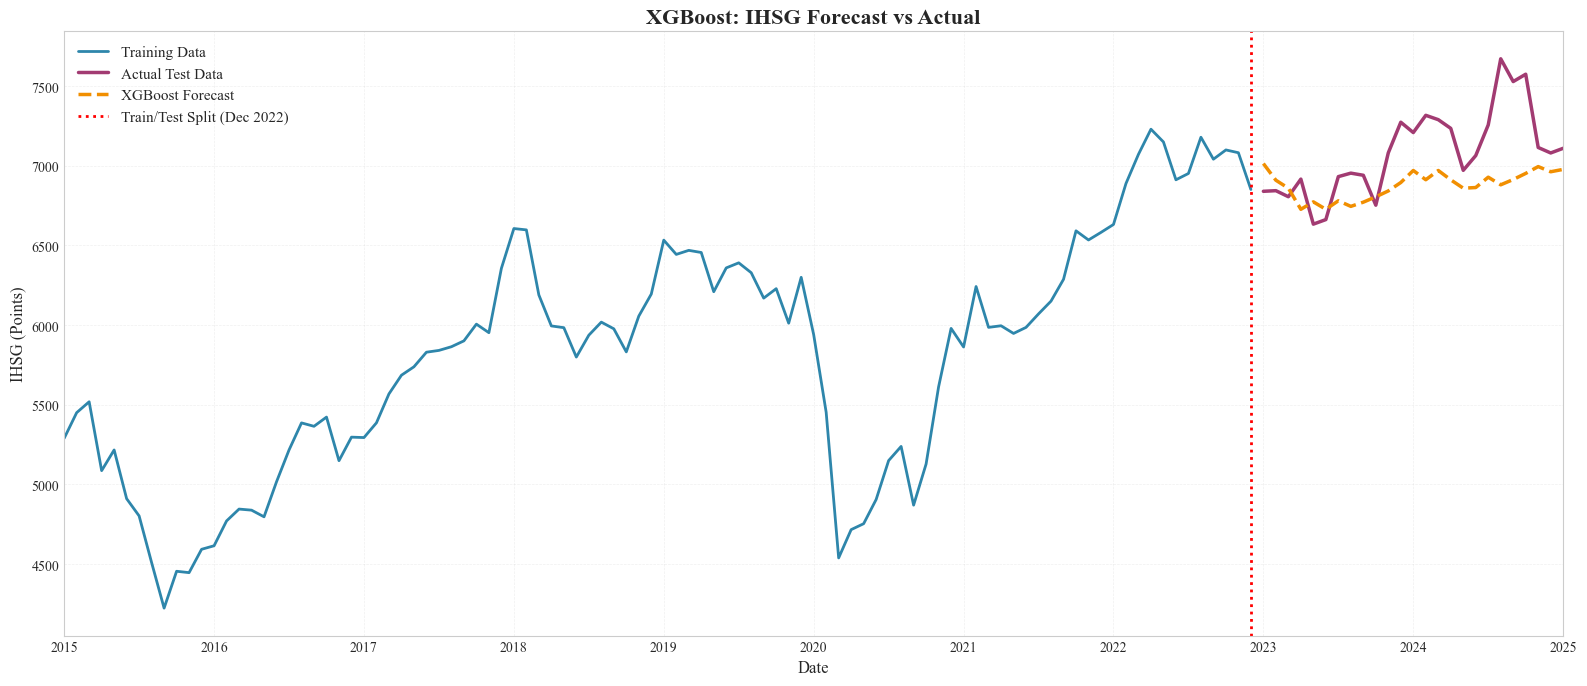

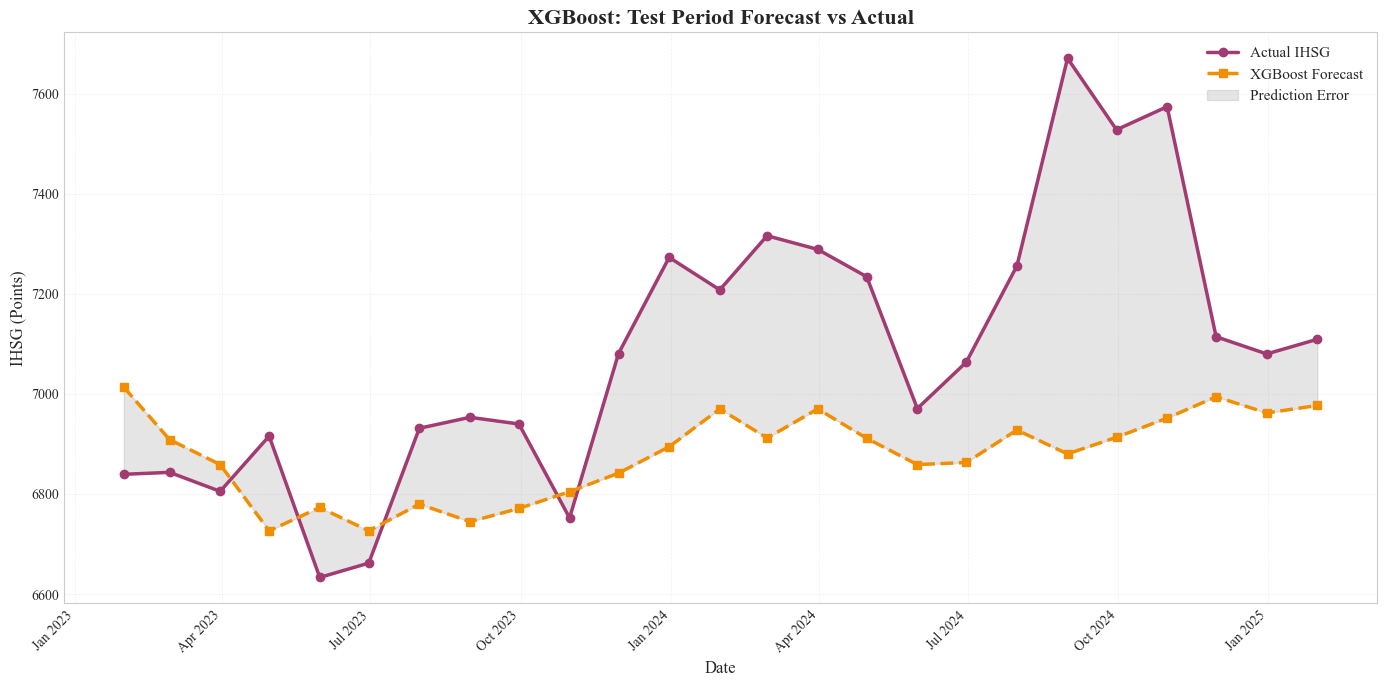

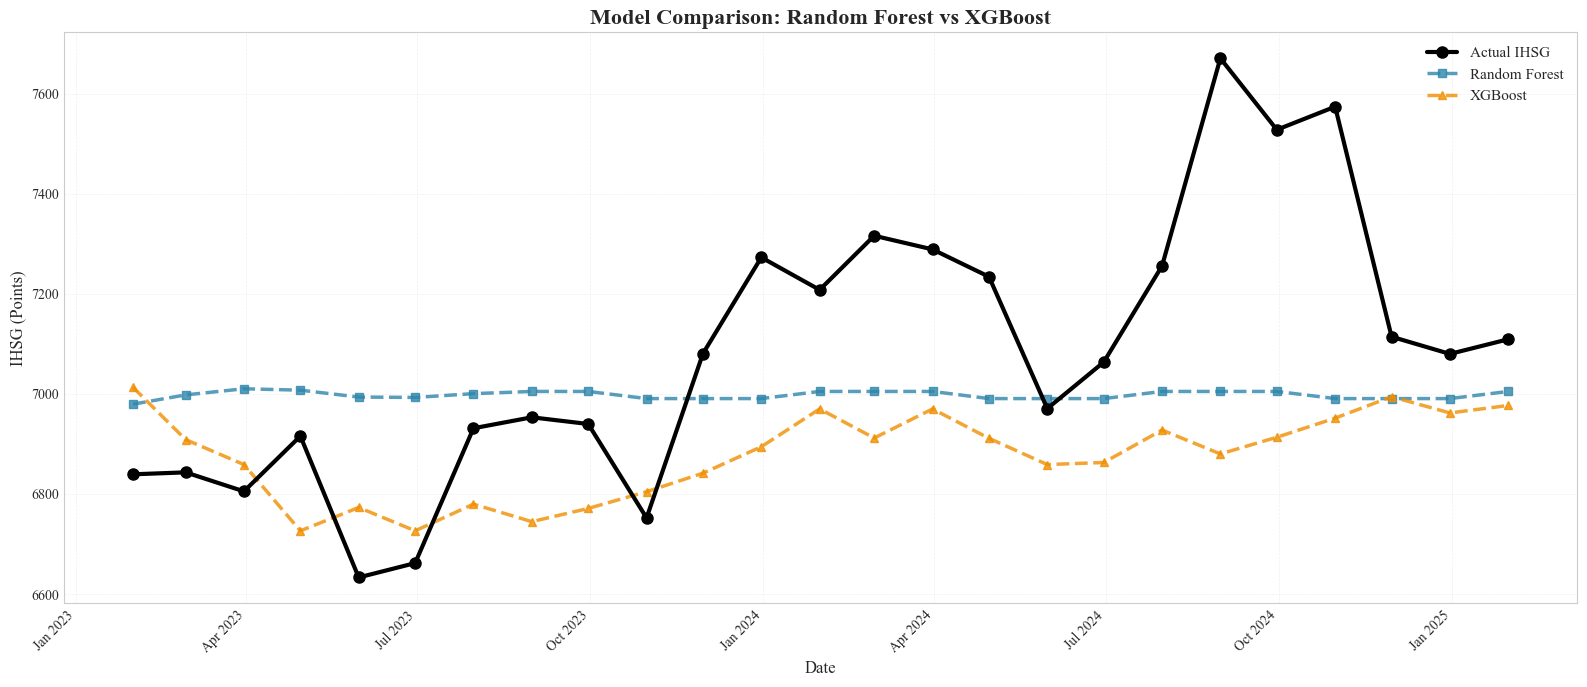

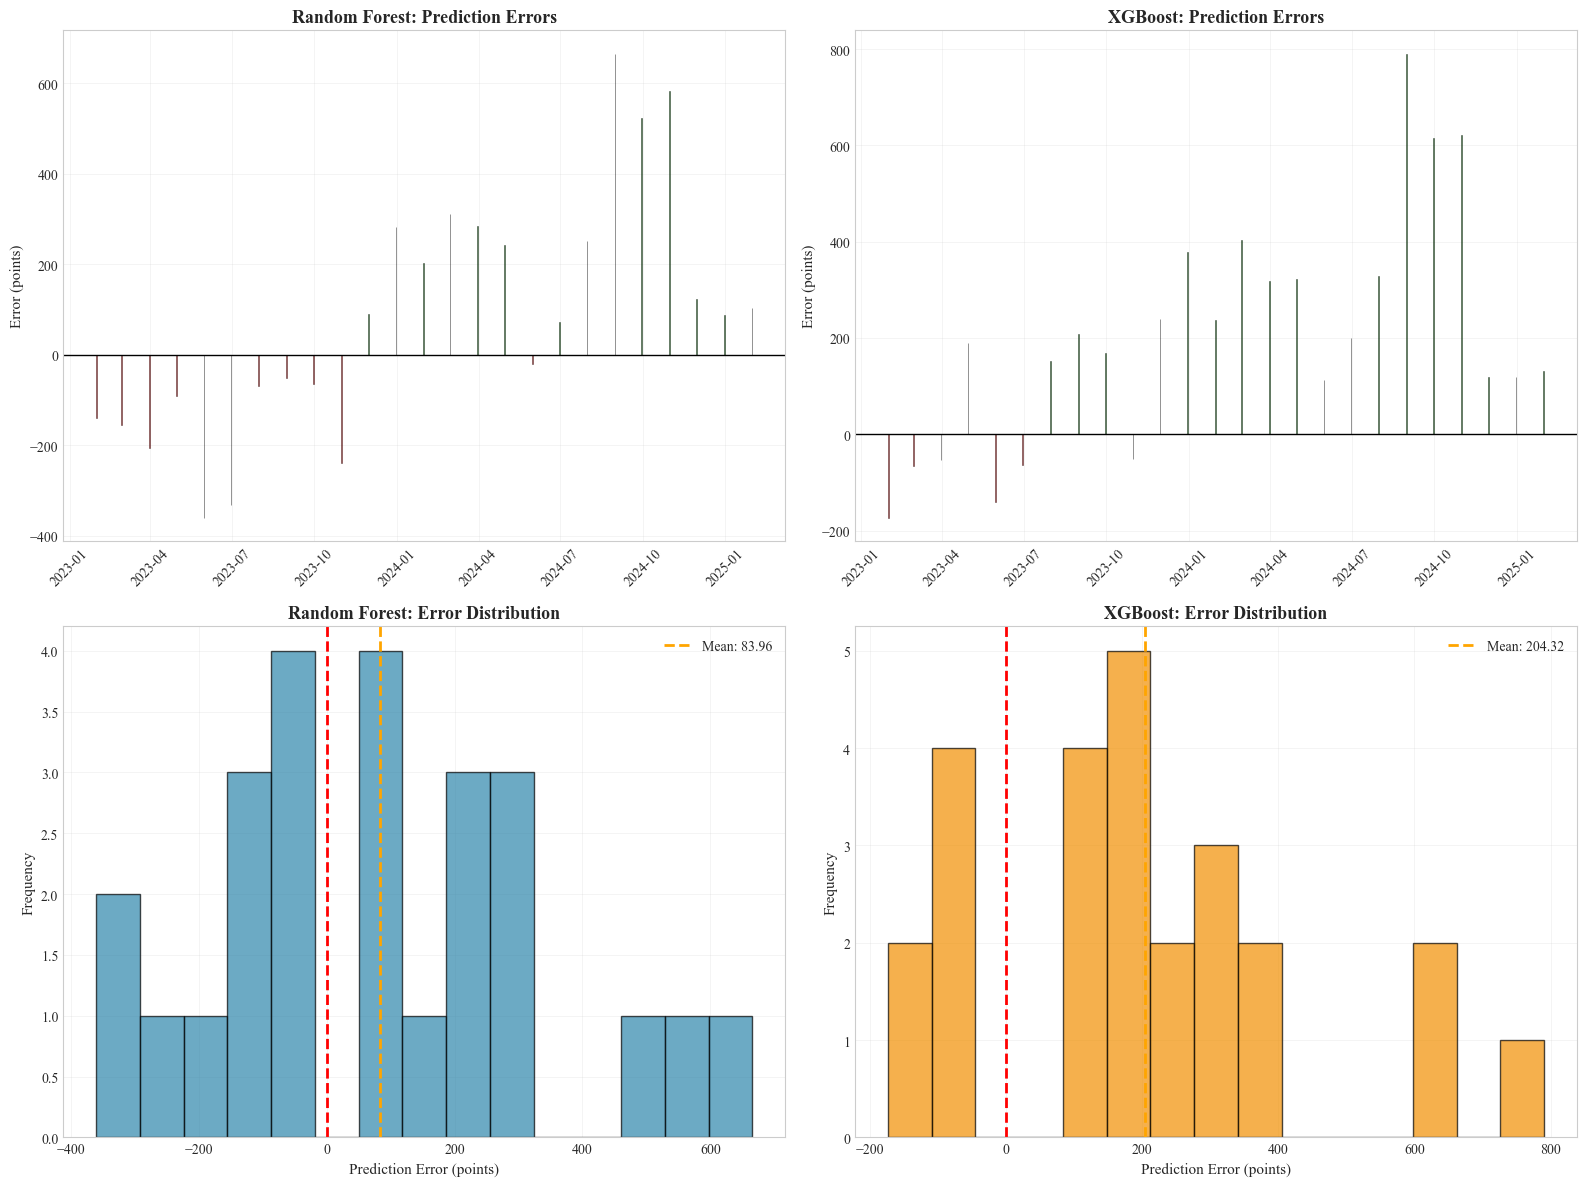

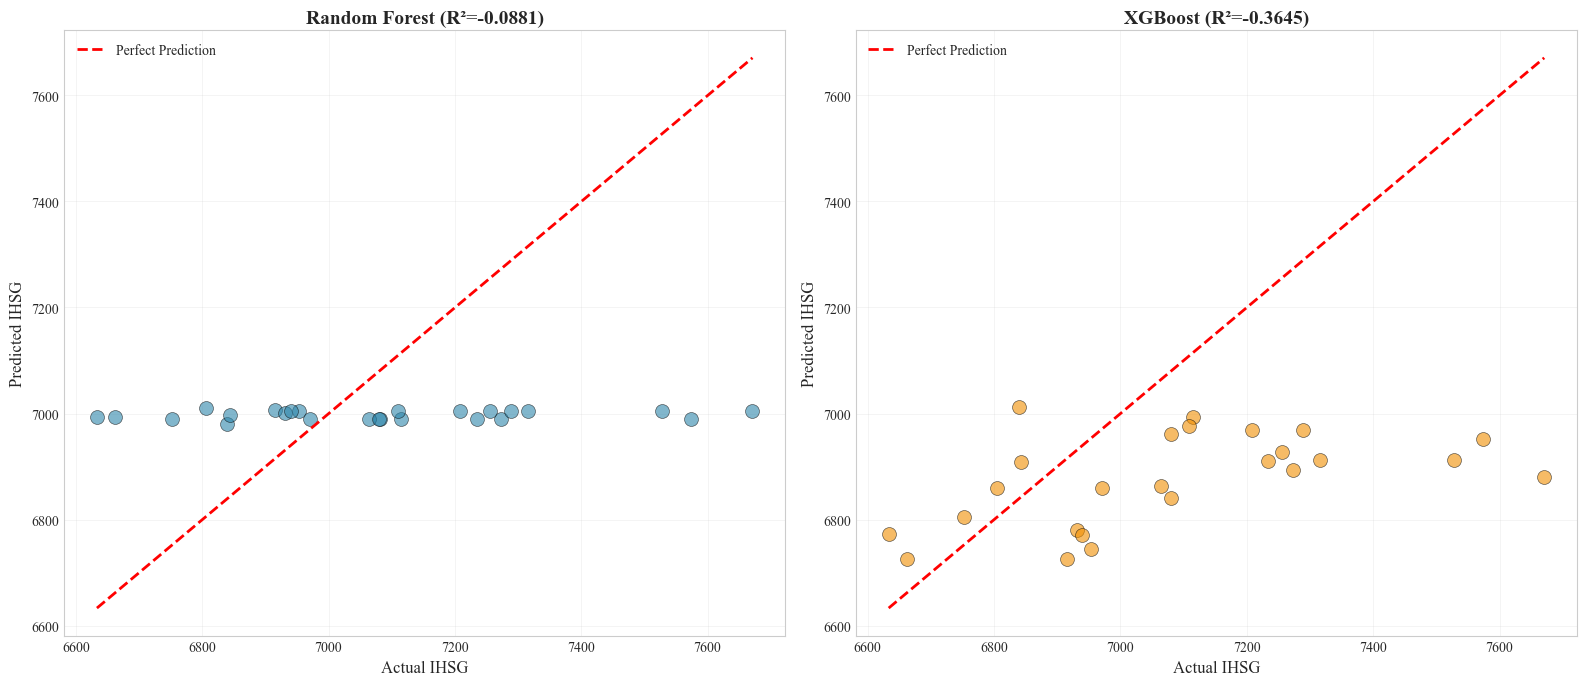

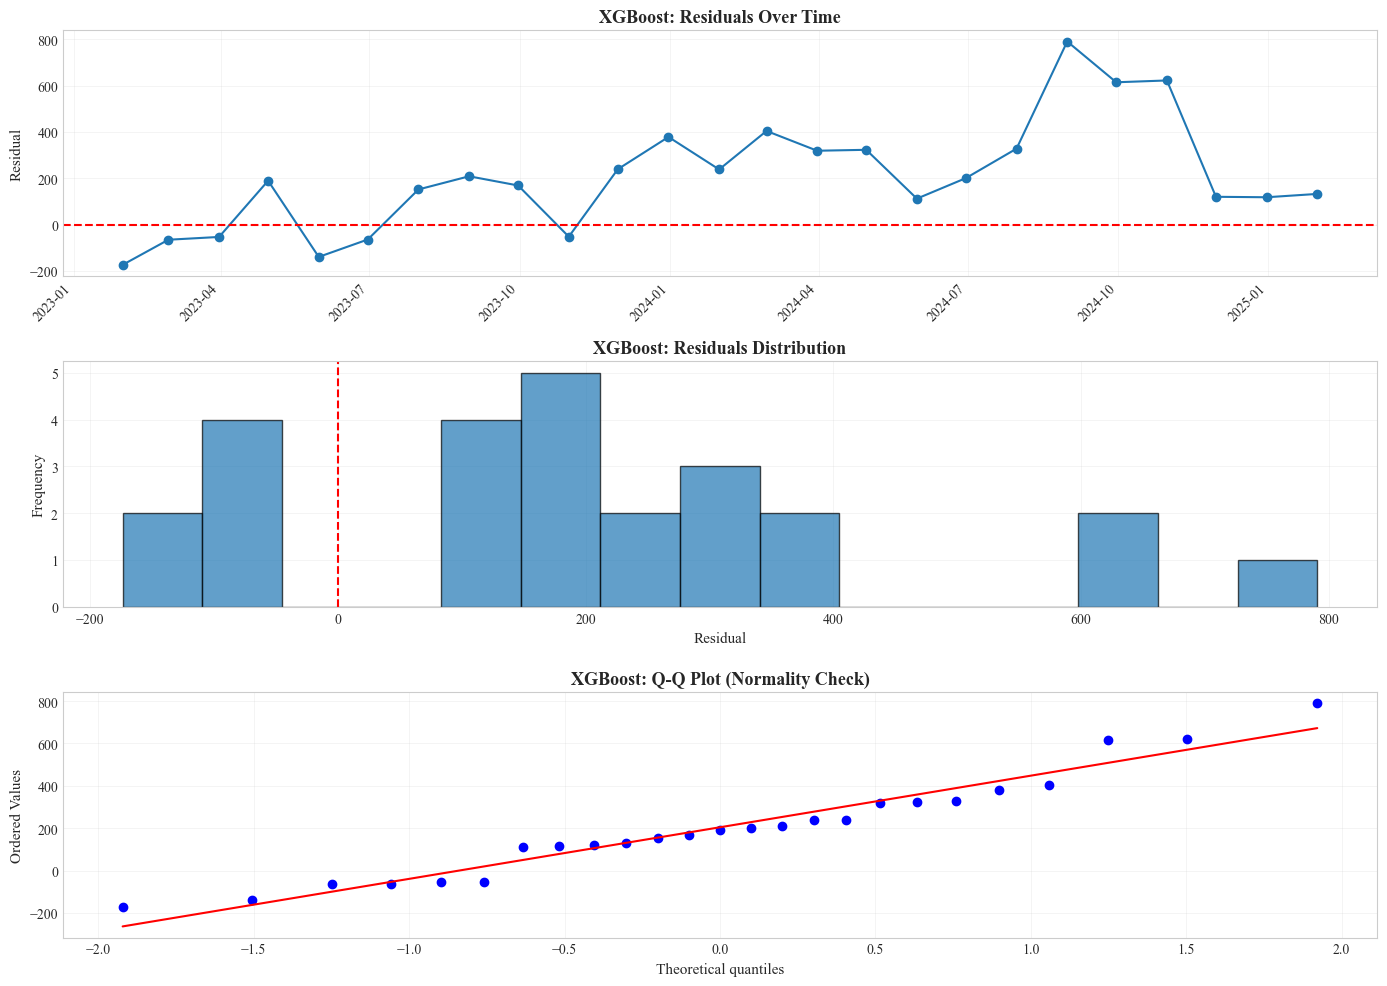


XGBOOST RESIDUAL DIAGNOSTICS
Mean Residual: 204.3250 (should be ~0)
Std Residual:  234.3910

Shapiro-Wilk Test (Normality):
  Statistic: 0.9493, p-value: 0.2412
  ✓ Residuals are normally distributed

RESULTS SAVED
✓ model_comparison_rf_vs_xgb.csv
✓ xgboost_predictions.csv

✅ XGBoost analysis complete!


In [46]:
# =====================================================
# XGBOOST MODEL - COMPLETE ANALYSIS
# =====================================================

# =====================================================
# 1. MODEL PERFORMANCE EVALUATION
# =====================================================
from darts.metrics import rmse, mae, mape, smape, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Inverse transform to original scale
forecast_xgb_original = scaler_ihsg.inverse_transform(forecast_xgb)
test_original = scaler_ihsg.inverse_transform(ihsg_test_scaled)

print("="*70)
print("XGBOOST MODEL PERFORMANCE METRICS (Original Scale)")
print("="*70)

# Calculate metrics
metrics_xgb = {
    'RMSE': rmse(test_original, forecast_xgb_original),
    'MAE': mae(test_original, forecast_xgb_original),
    'MAPE': mape(test_original, forecast_xgb_original),
    'sMAPE': smape(test_original, forecast_xgb_original),
    'R²': r2_score(test_original, forecast_xgb_original)
}

for metric, value in metrics_xgb.items():
    if metric in ['RMSE', 'MAE']:
        print(f"{metric:8s}: {value:>10.2f} points")
    elif metric in ['MAPE', 'sMAPE']:
        print(f"{metric:8s}: {value:>10.4f}%")
    else:
        print(f"{metric:8s}: {value:>10.4f}")

# Add context
avg_ihsg = test_original.values().mean()
print(f"\nAverage IHSG in test period: {avg_ihsg:.2f}")
print(f"RMSE as % of avg IHSG: {(metrics_xgb['RMSE']/avg_ihsg)*100:.2f}%")
print(f"MAE as % of avg IHSG:  {(metrics_xgb['MAE']/avg_ihsg)*100:.2f}%")

# =====================================================
# 2. DIRECTIONAL ACCURACY
# =====================================================
print("\n" + "="*70)
print("DIRECTIONAL ACCURACY ANALYSIS")
print("="*70)

actual_values = test_original.values().flatten()
pred_values_xgb = forecast_xgb_original.values().flatten()

# Calculate returns
actual_returns = np.diff(actual_values)
pred_returns_xgb = np.diff(pred_values_xgb)

# Directional accuracy
direction_correct_xgb = np.sum((actual_returns > 0) == (pred_returns_xgb > 0))
directional_accuracy_xgb = direction_correct_xgb / len(actual_returns) * 100

print(f"Directional Accuracy: {directional_accuracy_xgb:.2f}%")
print(f"(Baseline random guess: 50%)")
print(f"Correct predictions: {direction_correct_xgb}/{len(actual_returns)}")

# =====================================================
# 3. MODEL COMPARISON: XGBoost vs Random Forest
# =====================================================
print("\n" + "="*70)
print("MODEL COMPARISON: XGBoost vs Random Forest")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['MAPE (%)', 'RMSE (points)', 'MAE (points)', 'sMAPE (%)', 'R²', 'Directional Acc (%)'],
    'Random Forest': [
        metrics['MAPE'],
        metrics['RMSE'],
        metrics['MAE'],
        metrics['sMAPE'],
        metrics['R²'],
        directional_accuracy
    ],
    'XGBoost': [
        metrics_xgb['MAPE'],
        metrics_xgb['RMSE'],
        metrics_xgb['MAE'],
        metrics_xgb['sMAPE'],
        metrics_xgb['R²'],
        directional_accuracy_xgb
    ]
})

# Add winner column
comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'RF' if (
        (row.name in [0, 1, 2, 3] and row['Random Forest'] < row['XGBoost']) or
        (row.name in [4, 5] and row['Random Forest'] > row['XGBoost'])
    ) else 'XGB' if (
        (row.name in [0, 1, 2, 3] and row['XGBoost'] < row['Random Forest']) or
        (row.name in [4, 5] and row['XGBoost'] > row['Random Forest'])
    ) else 'Tie',
    axis=1
)

print(comparison_df.to_string(index=False))

# Count wins
rf_wins = (comparison_df['Winner'] == 'RF').sum()
xgb_wins = (comparison_df['Winner'] == 'XGB').sum()
ties = (comparison_df['Winner'] == 'Tie').sum()

print(f"\n📊 Score: RF: {rf_wins} | XGB: {xgb_wins} | Tie: {ties}")

# Determine overall winner
if rf_wins > xgb_wins:
    print(f"🏆 Overall Winner: Random Forest")
elif xgb_wins > rf_wins:
    print(f"🏆 Overall Winner: XGBoost")
else:
    print(f"🤝 Models are equally competitive")

# =====================================================
# 4. VISUALIZATION: XGBoost Forecast vs Actual
# =====================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Complete timeline
plt.figure(figsize=(16, 7))

train_original = scaler_ihsg.inverse_transform(ihsg_train_scaled)
train_original.plot(label="Training Data", color='#2E86AB', linewidth=2)
test_original.plot(label="Actual Test Data", color='#A23B72', linewidth=2.5)
forecast_xgb_original.plot(label="XGBoost Forecast", color='#F18F01', linewidth=2.5, linestyle='--')

split_date = train_original.end_time()
plt.axvline(x=split_date, color='red', linestyle=':', linewidth=2, 
            label=f'Train/Test Split ({split_date.strftime("%b %Y")})')

plt.title('XGBoost: IHSG Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Plot 2: Test period only (zoomed)
plt.figure(figsize=(14, 7))

test_dates = test_original.time_index

plt.plot(test_dates, actual_values, marker='o', markersize=6, 
         linewidth=2.5, color='#A23B72', label='Actual IHSG', linestyle='-')
plt.plot(test_dates, pred_values_xgb, marker='s', markersize=6, 
         linewidth=2.5, color='#F18F01', label='XGBoost Forecast', linestyle='--')

plt.fill_between(test_dates, actual_values, pred_values_xgb, 
                 alpha=0.2, color='gray', label='Prediction Error')

plt.title('XGBoost: Test Period Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# 5. SIDE-BY-SIDE MODEL COMPARISON PLOT
# =====================================================
plt.figure(figsize=(16, 7))

# Get RF forecast
forecast_rf_original = scaler_ihsg.inverse_transform(forecast)
pred_values_rf = forecast_rf_original.values().flatten()

plt.plot(test_dates, actual_values, marker='o', markersize=8, 
         linewidth=3, color='black', label='Actual IHSG', zorder=3)
plt.plot(test_dates, pred_values_rf, marker='s', markersize=6, 
         linewidth=2.5, color='#2E86AB', label='Random Forest', linestyle='--', alpha=0.8)
plt.plot(test_dates, pred_values_xgb, marker='^', markersize=6, 
         linewidth=2.5, color='#F18F01', label='XGBoost', linestyle='--', alpha=0.8)

plt.title('Model Comparison: Random Forest vs XGBoost', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# 6. ERROR ANALYSIS COMPARISON
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Errors
errors_rf = actual_values - pred_values_rf
errors_xgb = actual_values - pred_values_xgb

# Plot 1: RF Errors over time
axes[0, 0].bar(test_dates, errors_rf, 
               color=['green' if e > 0 else 'red' for e in errors_rf],
               alpha=0.6, edgecolor='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 0].set_title('Random Forest: Prediction Errors', fontweight='bold')
axes[0, 0].set_ylabel('Error (points)')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: XGB Errors over time
axes[0, 1].bar(test_dates, errors_xgb,
               color=['green' if e > 0 else 'red' for e in errors_xgb],
               alpha=0.6, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 1].set_title('XGBoost: Prediction Errors', fontweight='bold')
axes[0, 1].set_ylabel('Error (points)')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: RF Error distribution
axes[1, 0].hist(errors_rf, bins=15, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=errors_rf.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {errors_rf.mean():.2f}')
axes[1, 0].set_title('Random Forest: Error Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Prediction Error (points)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: XGB Error distribution
axes[1, 1].hist(errors_xgb, bins=15, edgecolor='black', alpha=0.7, color='#F18F01')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=errors_xgb.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {errors_xgb.mean():.2f}')
axes[1, 1].set_title('XGBoost: Error Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Prediction Error (points)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# =====================================================
# 7. SCATTER PLOTS COMPARISON
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# RF Scatter
axes[0].scatter(actual_values, pred_values_rf, alpha=0.6, s=100, 
                color='#2E86AB', edgecolors='black', linewidth=0.5)
min_val = min(actual_values.min(), pred_values_rf.min())
max_val = max(actual_values.max(), pred_values_rf.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
             label='Perfect Prediction')
axes[0].set_xlabel('Actual IHSG', fontsize=12)
axes[0].set_ylabel('Predicted IHSG', fontsize=12)
axes[0].set_title(f'Random Forest (R²={metrics["R²"]:.4f})', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# XGB Scatter
axes[1].scatter(actual_values, pred_values_xgb, alpha=0.6, s=100, 
                color='#F18F01', edgecolors='black', linewidth=0.5)
min_val = min(actual_values.min(), pred_values_xgb.min())
max_val = max(actual_values.max(), pred_values_xgb.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
             label='Perfect Prediction')
axes[1].set_xlabel('Actual IHSG', fontsize=12)
axes[1].set_ylabel('Predicted IHSG', fontsize=12)
axes[1].set_title(f'XGBoost (R²={metrics_xgb["R²"]:.4f})', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =====================================================
# 8. RESIDUAL ANALYSIS - XGBoost
# =====================================================
from scipy import stats

residuals_xgb = errors_xgb

plt.figure(figsize=(14, 10))

# Residuals over time
plt.subplot(3, 1, 1)
plt.plot(test_dates, residuals_xgb, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('XGBoost: Residuals Over Time', fontweight='bold')
plt.ylabel('Residual')
plt.grid(True)
plt.xticks(rotation=45, ha='right')

# Residuals distribution
plt.subplot(3, 1, 2)
plt.hist(residuals_xgb, bins=15, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('XGBoost: Residuals Distribution', fontweight='bold')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)

# Q-Q plot
plt.subplot(3, 1, 3)
stats.probplot(residuals_xgb, dist="norm", plot=plt)
plt.title('XGBoost: Q-Q Plot (Normality Check)', fontweight='bold')
plt.grid(True)

plt.tight_layout()
plt.show()

# Statistical tests
shapiro_stat_xgb, shapiro_p_xgb = stats.shapiro(residuals_xgb)
jb_stat_xgb, jb_p_xgb = stats.jarque_bera(residuals_xgb)

print("\n" + "="*70)
print("XGBOOST RESIDUAL DIAGNOSTICS")
print("="*70)
print(f"Mean Residual: {np.mean(residuals_xgb):.4f} (should be ~0)")
print(f"Std Residual:  {np.std(residuals_xgb):.4f}")
print(f"\nShapiro-Wilk Test (Normality):")
print(f"  Statistic: {shapiro_stat_xgb:.4f}, p-value: {shapiro_p_xgb:.4f}")
print(f"  {'✓ Residuals are normally distributed' if shapiro_p_xgb > 0.05 else '✗ Residuals not normal'}")

# =====================================================
# 9. SAVE RESULTS
# =====================================================
# Save comparison results
comparison_df.to_csv('model_comparison_rf_vs_xgb.csv', index=False)

# Save XGBoost predictions
xgb_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual_values,
    'Predicted': pred_values_xgb,
    'Error': errors_xgb,
    'Absolute_Error': np.abs(errors_xgb),
    'Percentage_Error': np.abs(errors_xgb / actual_values) * 100
})
xgb_results_df.to_csv('xgboost_predictions.csv', index=False)

print("\n" + "="*70)
print("RESULTS SAVED")
print("="*70)
print("✓ model_comparison_rf_vs_xgb.csv")
print("✓ xgboost_predictions.csv")

print("\n✅ XGBoost analysis complete!")

In [47]:
# =====================================================
# FINAL COMPREHENSIVE SUMMARY - UPDATED WITH XGBoost
# =====================================================
print("\n" + "="*70)
print("HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI")
print("="*70)

# Data Information (sama seperti sebelumnya)
print("\n📊 DATA:")
print(f"   • Periode Data     : {df_clean['Date'].min().strftime('%B %Y')} - {df_clean['Date'].max().strftime('%B %Y')}")
print(f"   • Total Observasi  : {len(df_clean)} bulan")
print(f"   • Train/Test Split : {train_ratio*100:.0f}% / {(1-train_ratio)*100:.0f}%")
print(f"   • Train Period     : {ihsg_train.start_time().strftime('%B %Y')} - {ihsg_train.end_time().strftime('%B %Y')} ({len(ihsg_train)} obs)")
print(f"   • Test Period      : {ihsg_test.start_time().strftime('%B %Y')} - {ihsg_test.end_time().strftime('%B %Y')} ({len(ihsg_test)} obs)")

# Target & Covariates (sama)
print("\n🎯 TARGET:")
print(f"   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)")

print("\n📈 COVARIATES (Variabel Makroekonomi):")
covariate_cols = ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']
for i, col in enumerate(covariate_cols, 1):
    print(f"   {i}. {col}")

# MODEL COMPARISON TABLE
print("\n🤖 MODEL COMPARISON:")
print("="*70)
print(f"{'Metric':<25} {'Random Forest':>15} {'XGBoost':>15} {'Winner':>10}")
print("-"*70)
print(f"{'MAPE (%)':<25} {metrics['MAPE']:>15.4f} {metrics_xgb['MAPE']:>15.4f} {'RF' if metrics['MAPE'] < metrics_xgb['MAPE'] else 'XGB':>10}")
print(f"{'RMSE (points)':<25} {metrics['RMSE']:>15.2f} {metrics_xgb['RMSE']:>15.2f} {'RF' if metrics['RMSE'] < metrics_xgb['RMSE'] else 'XGB':>10}")
print(f"{'MAE (points)':<25} {metrics['MAE']:>15.2f} {metrics_xgb['MAE']:>15.2f} {'RF' if metrics['MAE'] < metrics_xgb['MAE'] else 'XGB':>10}")
print(f"{'R²':<25} {metrics['R²']:>15.4f} {metrics_xgb['R²']:>15.4f} {'RF' if metrics['R²'] > metrics_xgb['R²'] else 'XGB':>10}")
print(f"{'Directional Acc (%)':<25} {directional_accuracy:>15.2f} {directional_accuracy_xgb:>15.2f} {'RF' if directional_accuracy > directional_accuracy_xgb else 'XGB':>10}")

# Determine best model
if metrics['MAPE'] < metrics_xgb['MAPE']:
    best_model_name = "Random Forest"
    best_metrics = metrics
    best_dir_acc = directional_accuracy
else:
    best_model_name = "XGBoost"
    best_metrics = metrics_xgb
    best_dir_acc = directional_accuracy_xgb

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • MAPE: {best_metrics['MAPE']:.4f}%")
print(f"   • R²: {best_metrics['R²']:.4f}")

# Best Hyperparameters for both models
print(f"\n⚙️ BEST HYPERPARAMETERS:")
print(f"\nRandom Forest:")
for param, value in best_params.items():
    print(f"   • {param:<25}: {value}")

print(f"\nXGBoost:")
for param, value in best_params_xgb.items():
    print(f"   • {param:<25}: {value}")

# SHAP Feature Importance
print("\n🔍 FEATURE IMPORTANCE (SHAP - Random Forest):")
print(f"\n   Top 5 Most Important Features:")
for i, row in enumerate(feature_importance_df.head(5).itertuples(), 1):
    pct = (row.Mean_Abs_SHAP / feature_importance_df['Mean_Abs_SHAP'].sum()) * 100
    print(f"   {i}. {row.Feature:<40} : {pct:>5.2f}% [{row.Category}]")

print(f"\n   Category Ranking:")
total_shap = category_importance.sum()
for i, (category, importance) in enumerate(category_importance.items(), 1):
    pct = (importance / total_shap) * 100
    print(f"   {i}. {category:<20} : {pct:>6.2f}%")

# Key Findings
print("\n💡 KEY FINDINGS:")
print(f"   1. {best_model_name} outperforms with {best_metrics['MAPE']:.2f}% MAPE")
print(f"   2. Both models achieve >50% directional accuracy (RF: {directional_accuracy:.1f}%, XGB: {directional_accuracy_xgb:.1f}%)")
print(f"   3. {category_importance.index[0]} is the most influential category")
print(f"   4. Model explains {best_metrics['R²']*100:.1f}% of IHSG variance")

# Footer
print("\n" + "="*70)
print(f"Best Model: {best_model_name}")
print("Horizon: 1 month ahead forecast")
print("Source: Author's calculation, 2025")
print("="*70)


HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI

📊 DATA:
   • Periode Data     : January 2015 - January 2025
   • Total Observasi  : 121 bulan
   • Train/Test Split : 80% / 20%
   • Train Period     : January 2015 - December 2022 (96 obs)
   • Test Period      : January 2023 - January 2025 (25 obs)

🎯 TARGET:
   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)

📈 COVARIATES (Variabel Makroekonomi):
   1. Inflation_YoY
   2. M2_YoY
   3. USDIDR
   4. BI_Rate
   5. NPL_Ratio

🤖 MODEL COMPARISON:
Metric                      Random Forest         XGBoost     Winner
----------------------------------------------------------------------
MAPE (%)                           3.0925          3.4242         RF
RMSE (points)                      277.67          310.95         RF
MAE (points)                       222.17          248.30         RF
R²                                -0.0881         -0.3645         RF
Directional Acc (%)                 58.33           45.83        